# Homework 1

### Installing packages

In [2]:
!pip install langchain_google_genai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.4/719.4 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.5/236.5 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.43.0
    Uninstalling google-auth-2.43.0:
      Successfully uninstalled google-auth-2.43.0
  Attempting uninstall: google-genai
    Found existing installation: google-genai 1.55.0
    Uninstalling google-genai-1.55.0:
      Successfully uninstalled google-genai-1.55.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.48.0 which is incompatible.


## Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `VERTEX_API_KEY`.


1.   Look for the key icon on the left panel of your colab.
2.   Under `Name`, create `VERTEX_API_KEY`.
3. Copy your key to `Value`.




In [1]:
from google.colab import userdata
GEMINI_VERTEX_API_KEY = userdata.get('VERTEX_API_KEY')

## Downloading receipts.zip
The codes below download and unzip receipts.zip from Google Drive. receipts.zip contains all images from the Fusion folder on BlackBoard.


In [2]:
import gdown
file_id = "1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF"
download_url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(download_url, "receipts.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF
To: /content/receipts.zip
100%|██████████| 1.61M/1.61M [00:00<00:00, 31.8MB/s]


'receipts.zip'

In [3]:
!unzip receipts.zip

Archive:  receipts.zip
  inflating: receipt1.jpg            
  inflating: __MACOSX/._receipt1.jpg  
  inflating: receipt2.jpg            
  inflating: __MACOSX/._receipt2.jpg  
  inflating: receipt3.jpg            
  inflating: __MACOSX/._receipt3.jpg  
  inflating: receipt4.jpg            
  inflating: __MACOSX/._receipt4.jpg  
  inflating: receipt5.jpg            
  inflating: __MACOSX/._receipt5.jpg  
  inflating: receipt6.jpg            
  inflating: __MACOSX/._receipt6.jpg  
  inflating: receipt7.jpg            
  inflating: __MACOSX/._receipt7.jpg  


## 1. Helper functions

We need two functions
* image_to_base64 convert your jpg image into Base64 encoded string (basically a sequence of 64 characters to make your image easily transfered via API)
* get_image_data_url takes your jpg image, converting them into base64 string and construct a suitable input for GEMINI api call.

In [ ]:
import base64
import mimetypes

# Helper function to read and encode image
def image_to_base64(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Helper function to encode local file to Base64 Data URL
def get_image_data_url(image_path):
    # Guess the mime type (e.g., image/png, image/jpeg) based on file extension
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = "image/png" # Default fallback

    encoded_string = image_to_base64(image_path)

    # Construct the Data URL
    return f"data:{mime_type};base64,{encoded_string}"

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=userdata.get('VERTEX_API_KEY'), # Ensure this key is set in Colab secrets
    temperature=0,
    vertexai=True
)

Display jpg images. Alternatively, open the folder icon on the left pannel to see the images.


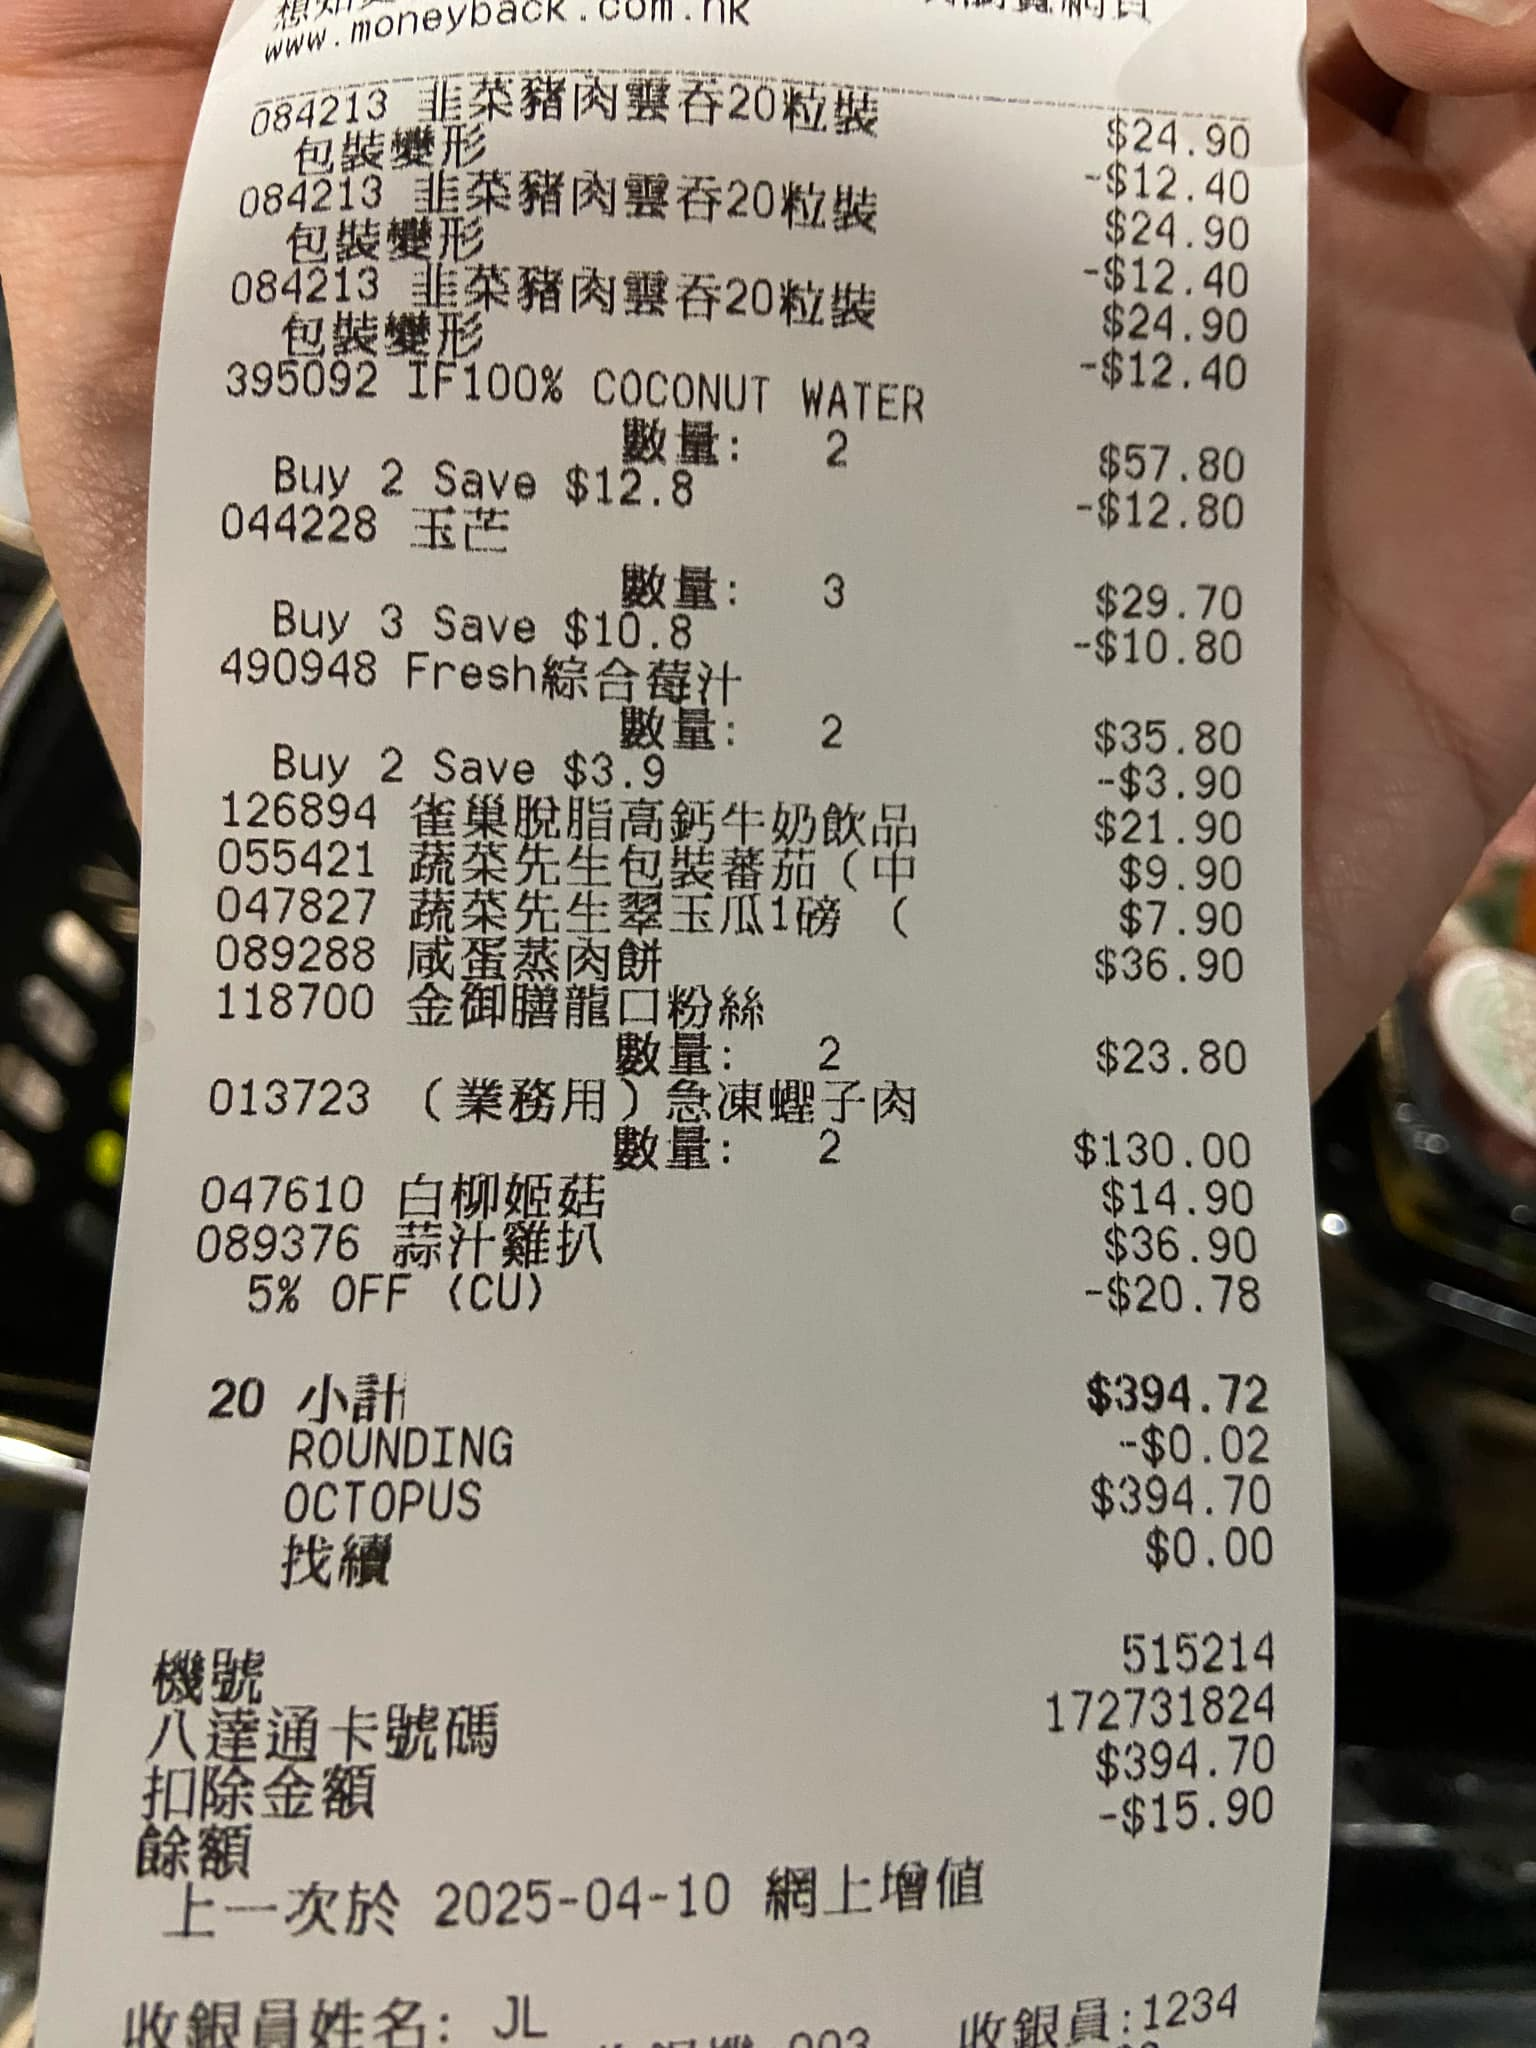
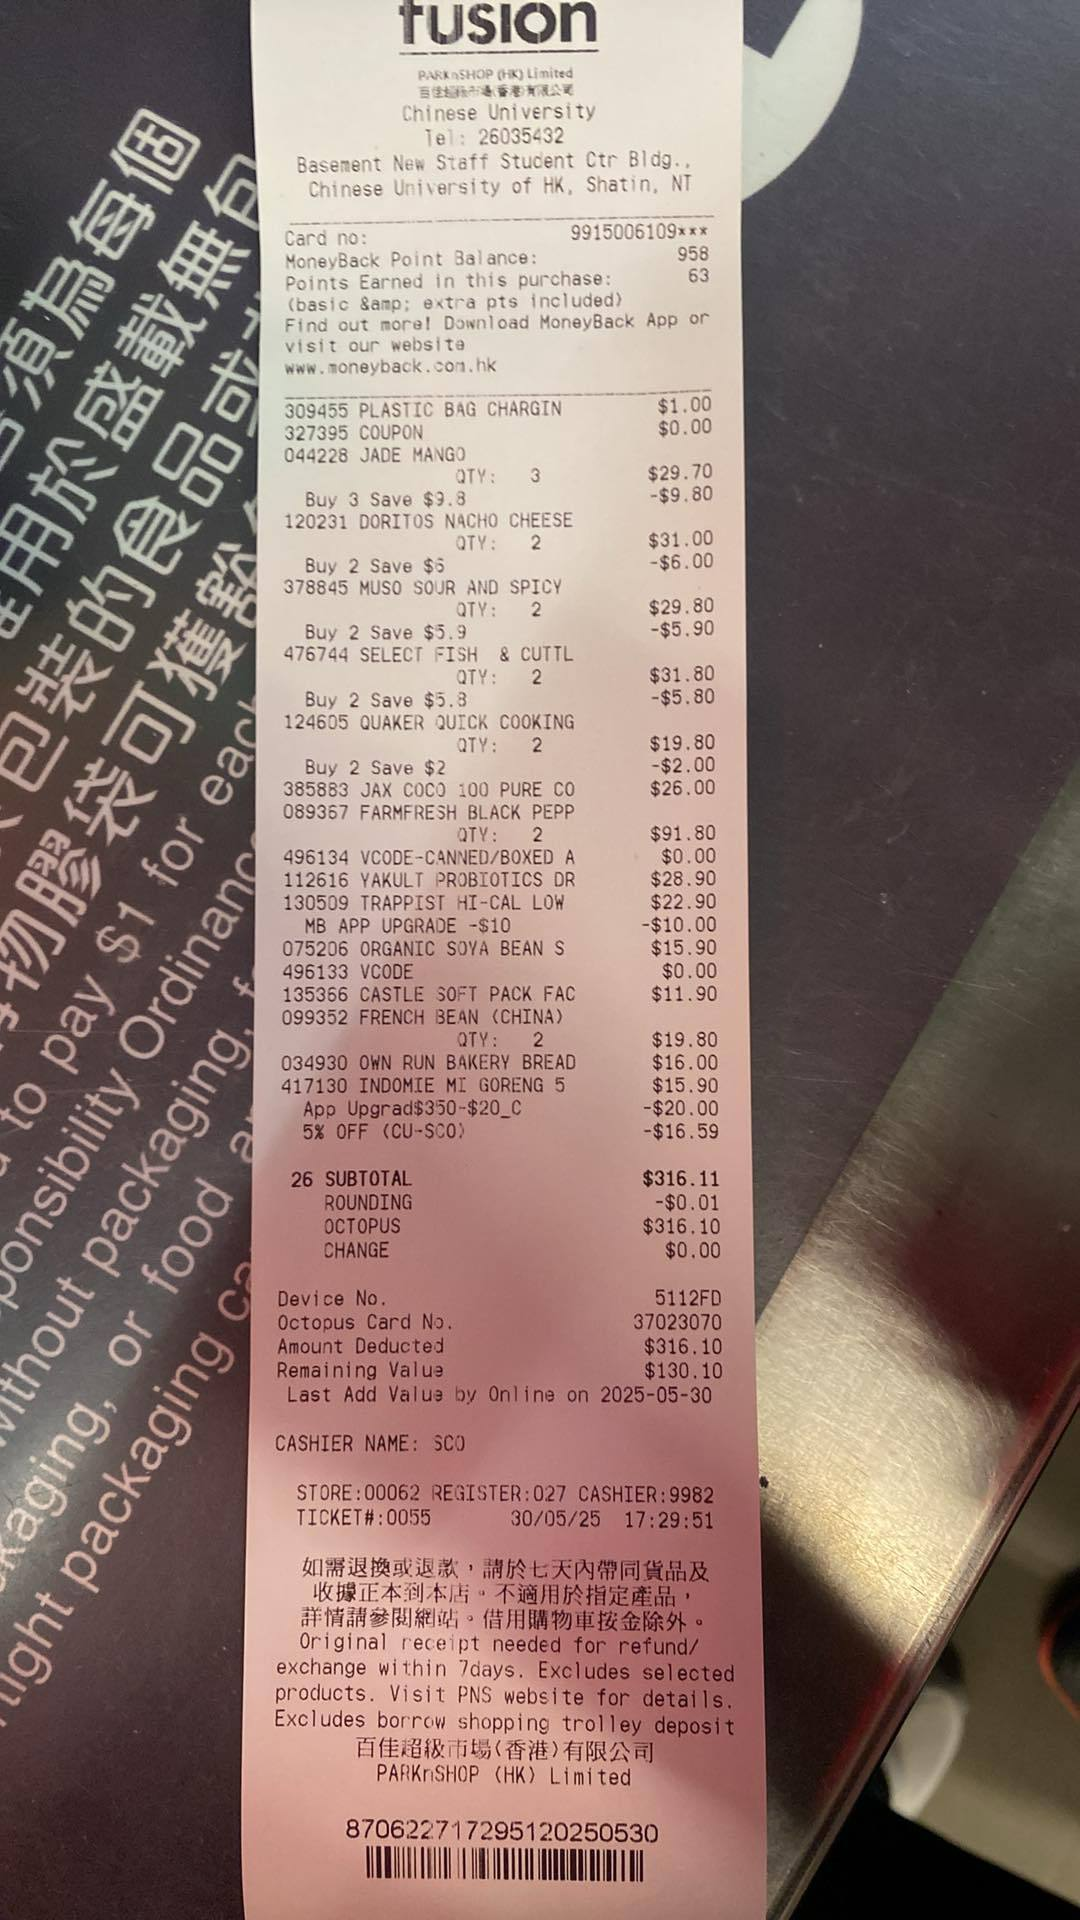
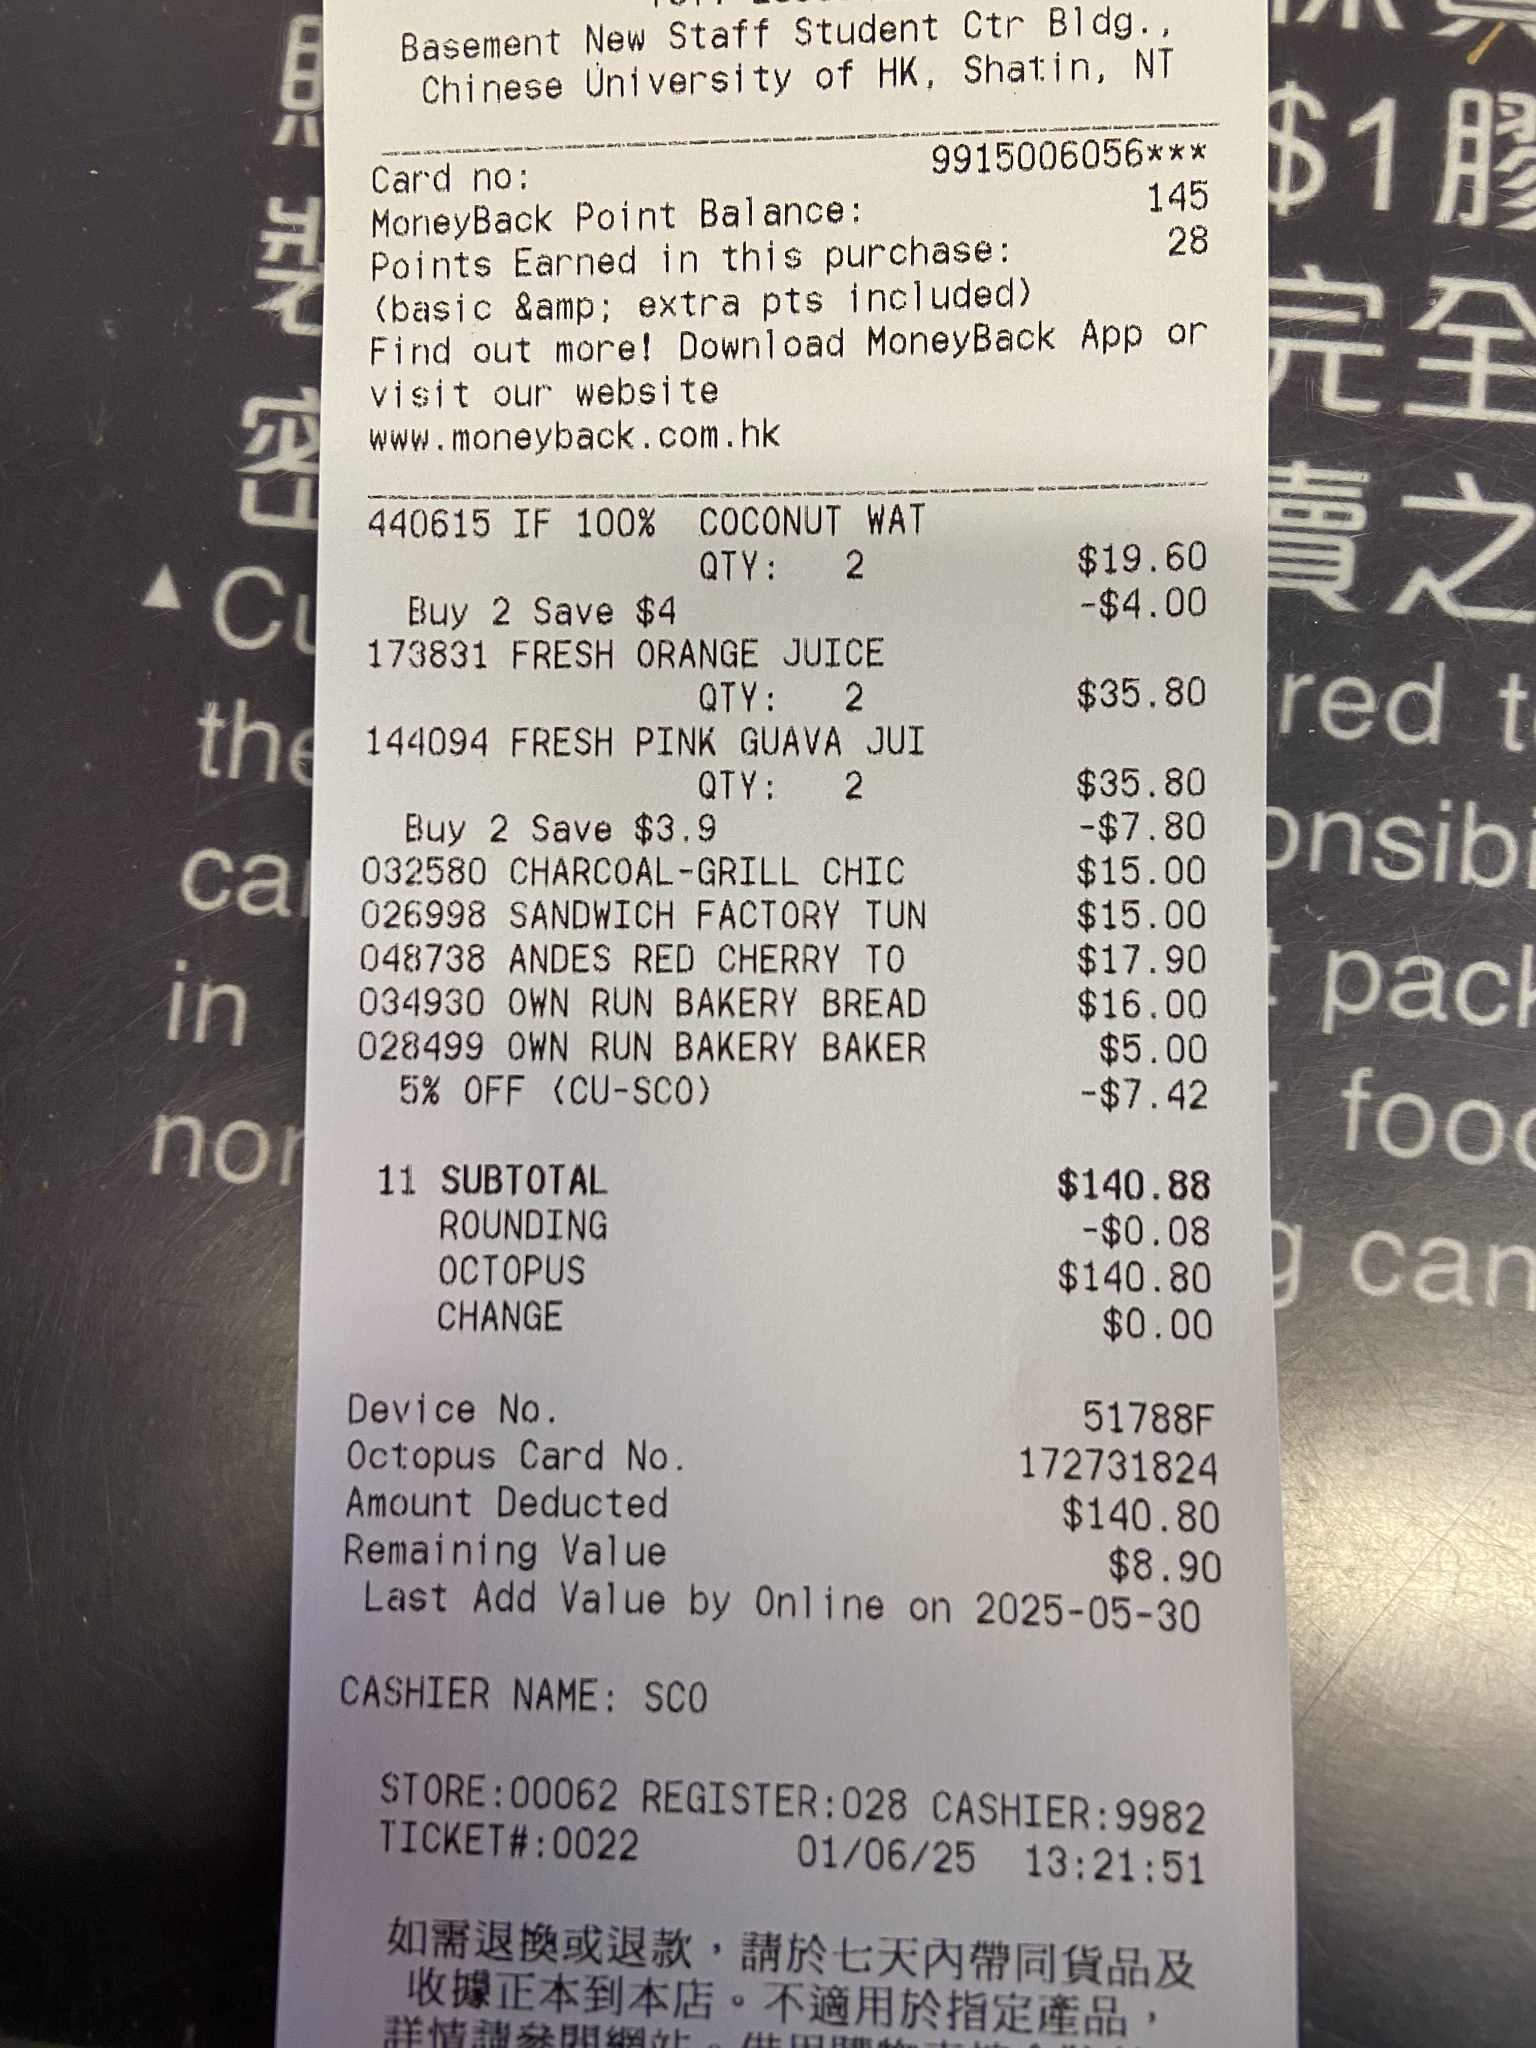
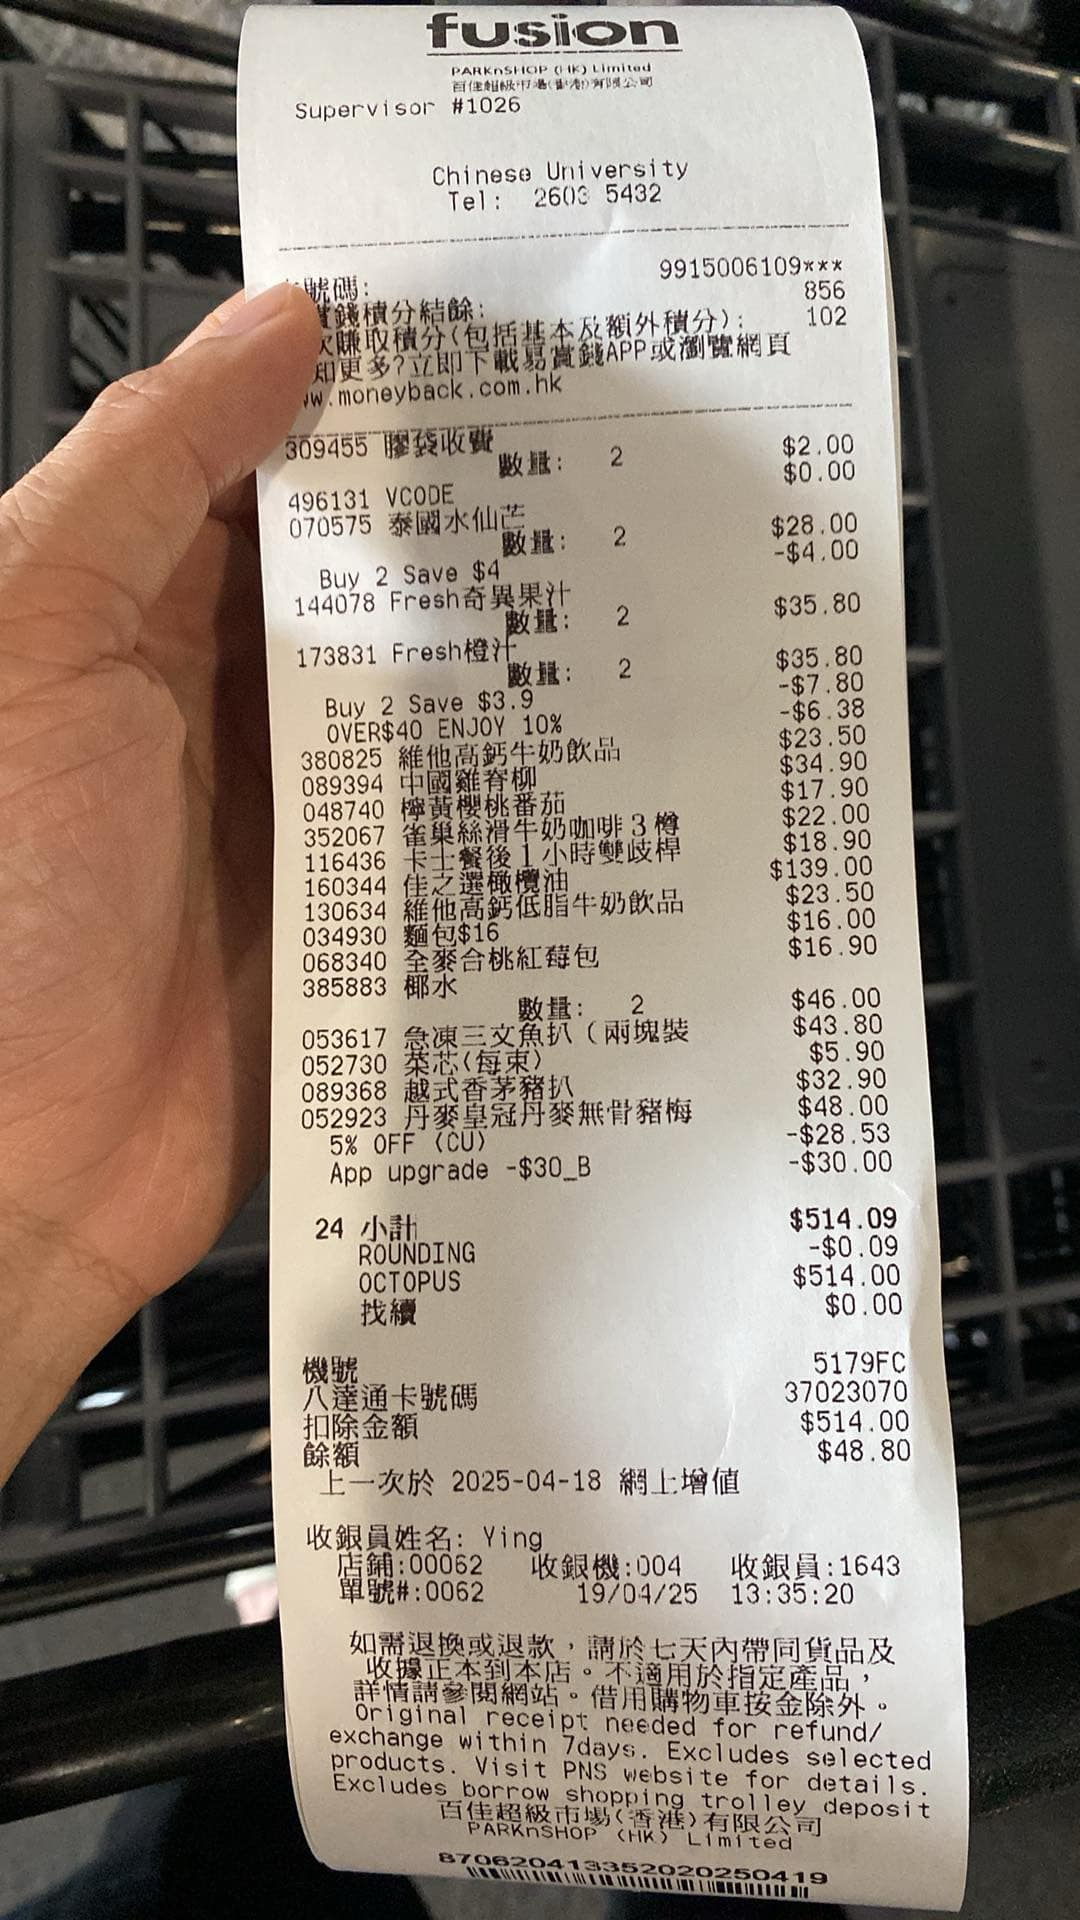
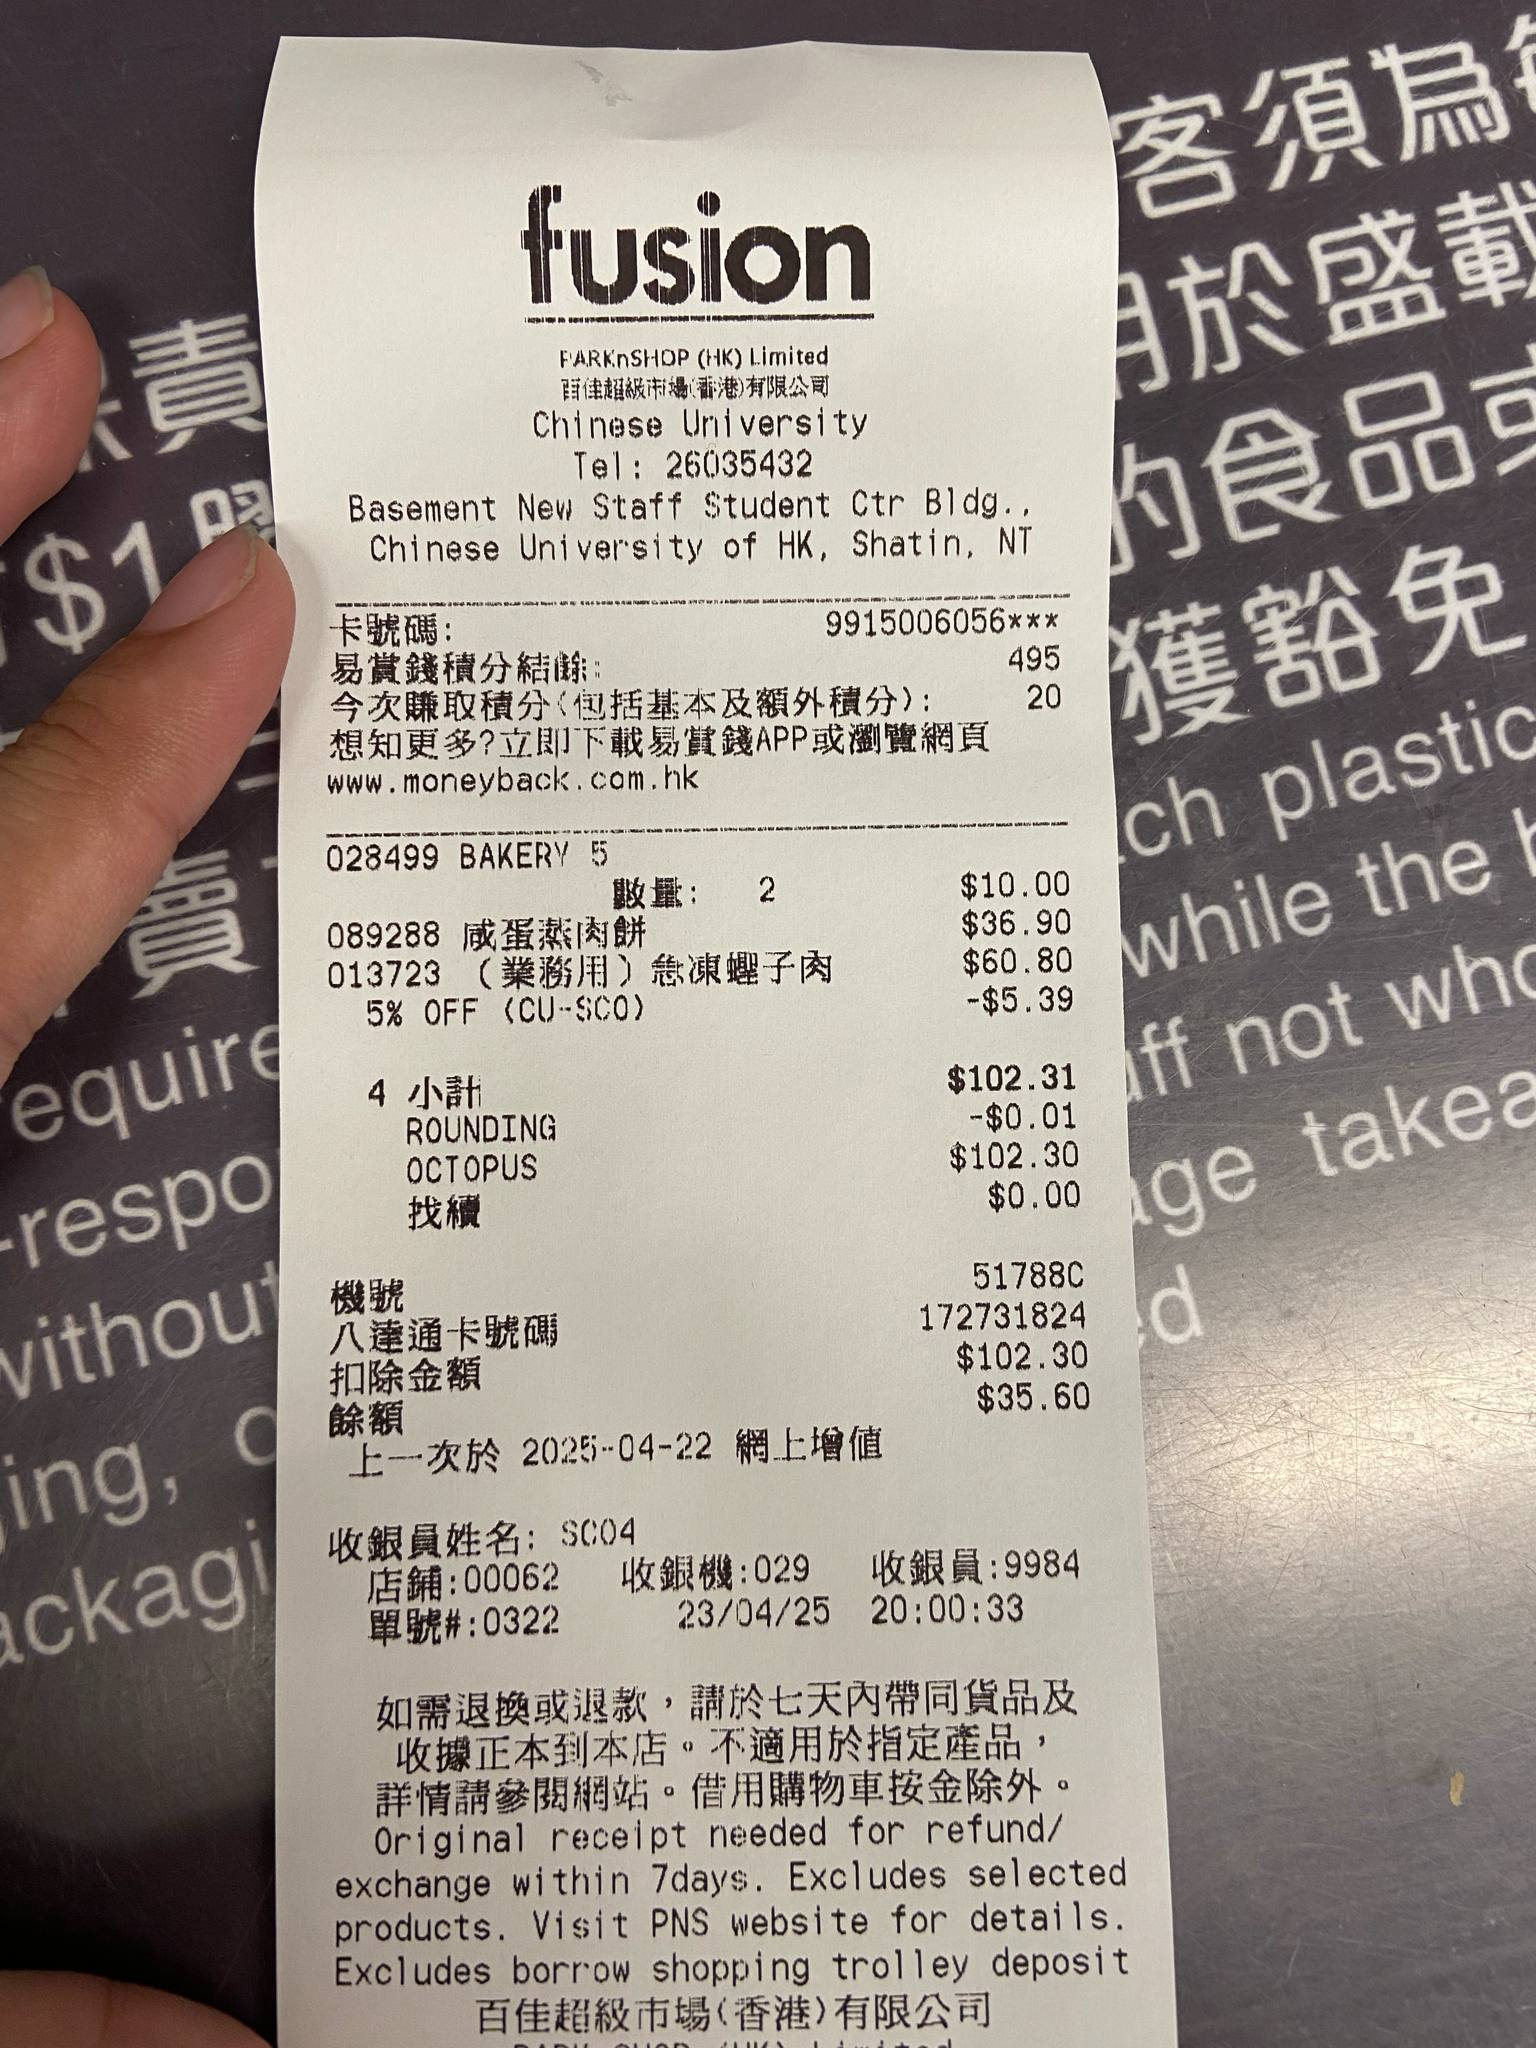
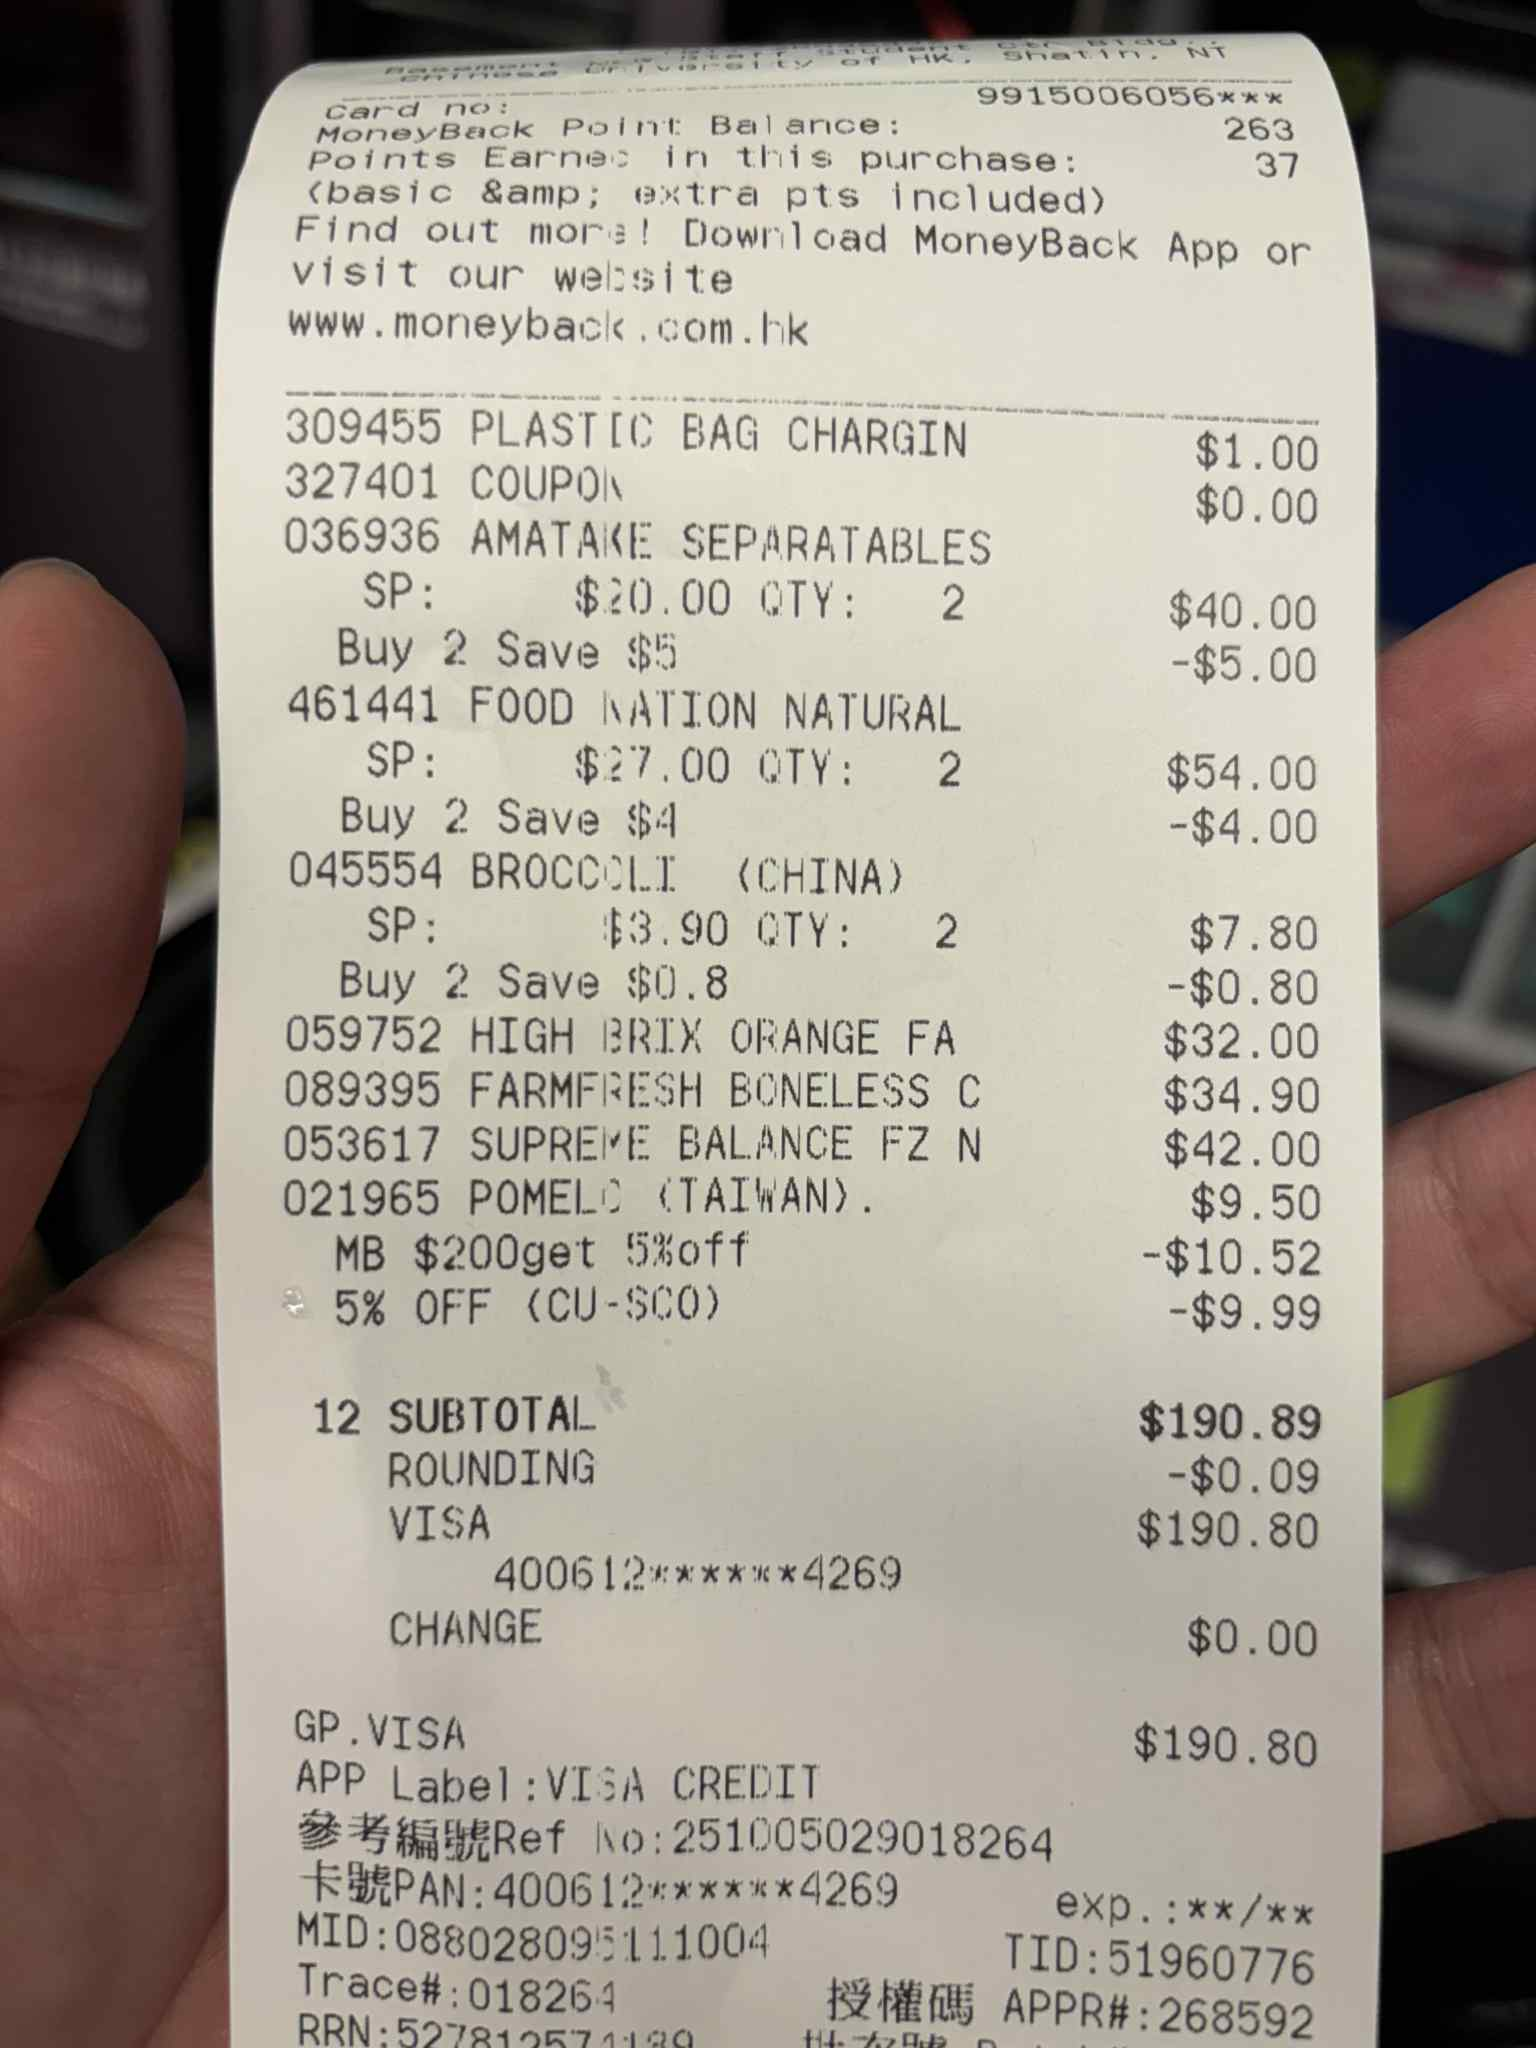
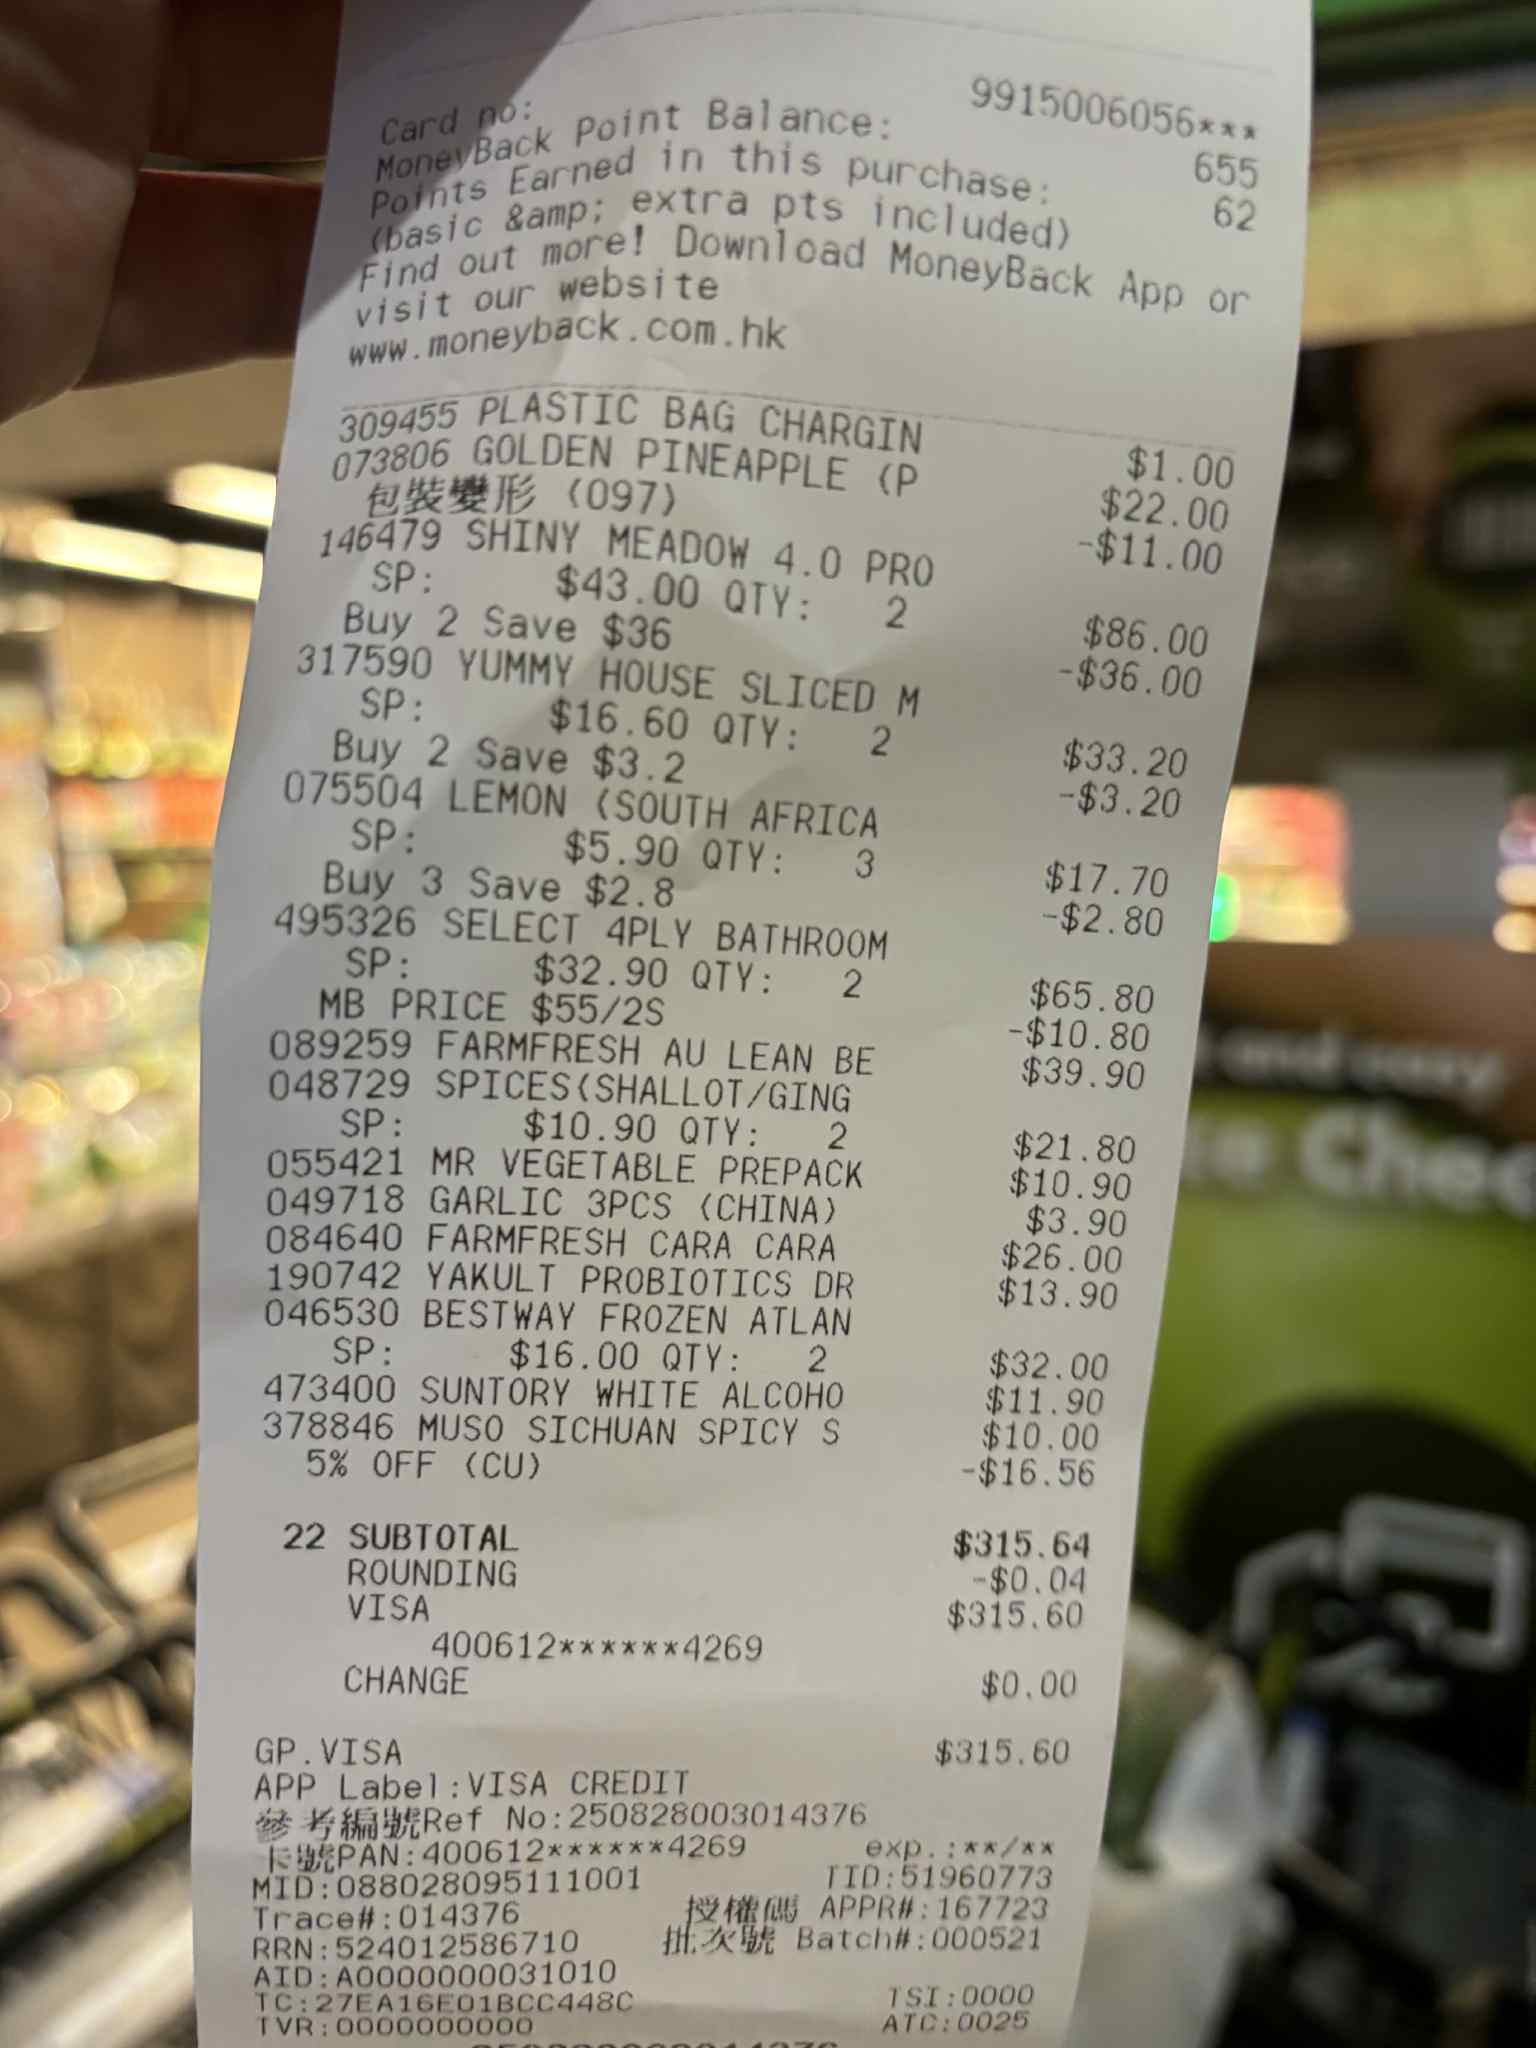

In [5]:
from IPython.display import HTML, display
import glob, os

image_paths = glob.glob("*.jpg")
image_paths.sort()
html_content = '<div style="display: flex; flex-wrap: wrap; gap: 20px;">'

for path in image_paths:
    b64 = image_to_base64(path)
    filename = os.path.basename(path) # Clean up path to show just the name

    # Create a vertical column for each image + text
    html_content += f'''
    <div style="display: flex; flex-direction: column; align-items: center;">
        <img src="data:image/jpeg;base64,{b64}" style="height: 300px; border: 1px solid #ddd; margin-bottom: 5px;"/>
        <span style="font-family: monospace; font-size: 14px;">{filename}</span>
    </div>
    '''

html_content += '</div>'

display(HTML(html_content))

## 2. Image input to Gemini
Different from text, image needs to be converted into base64 encoded string and then formated into url before inputting to the language model. This is convenient for image-type input to be transfered through the API.

You can find out more appropriate format for image-type data in this [Link](https://docs.langchain.com/oss/python/langchain/messages)



In [ ]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("human", [
        {"type": "text", "text": "{question}"},
        {"type": "image_url", "image_url": {"url": "{image_url1}"}},
        {"type": "image_url", "image_url": {"url": "{image_url2}"}},
    ]),
])

chain = prompt | llm

image_path = "/content/receipt1.jpg"
image_data_url = get_image_data_url(image_path)

image_path2 = "/content/receipt2.jpg"
image_data_url2 = get_image_data_url(image_path2)

response = chain.invoke({
    "question": "What is in this picture?",
    "image_url1": image_data_url,
    "image_url2": image_data_url2
})

print(response.content)

This picture contains **two grocery store receipts** from "Fusion by PARKnSHOP limited".

Here's a breakdown of what's on each receipt:

**Receipt 1 (Left Side):**

*   **Store:** Fusion by PARKnSHOP
*   **Items Purchased:**
    *   3 packs of Leek Pork Wontons (20 pcs each), with a discount for deformed packaging on each.
    *   2 units of IF100% Coconut Water (with a "Buy 2 Save" discount).
    *   3 units of Jade Beans / Edamame (with a "Buy 3 Save" discount).
    *   2 units of Fresh Mixed Juice (with a "Buy 2 Save" discount).
    *   Nestle Skimmed High Calcium Milk Drink.
    *   Mr. Vegetable Packaged Tomatoes (Medium).
    *   Mr. Vegetable Zucchini (1 lb).
    *   Steamed Pork Patty with Salted Egg.
    *   2 units of Golden Imperial Vermicelli.
    *   2 units of Frozen Shrimp Meat (Commercial Use).
    *   White Willow Mushrooms / Shimeji Mushrooms.
    *   Garlic Chicken Chop.
*   **Discounts:** Several "Buy X Save Y" discounts, packaging deformation discounts, and a 5% of

## 3. Evaluation Code

* Make sure your LLM return a single float as the answer, stored in `query1_answer` and `query2_answer`
* Run the following code blocks: (1) If the blocks does not return any error, then your chain design is correct. Otherwise, please check your chain design.

* Do not modify `query_1_costs` and `query_2_costs`

In [ ]:
def test_query(answer, ground_truth_costs):
    # Convert string to float if necessary
    if isinstance(answer, str):
        answer = float(answer)

    # Calculate the ground truth sum once for clarity
    expected_total = sum(ground_truth_costs)

    # Check if the answer is within +/- $2 of the expected total
    assert abs(answer - expected_total) <= 2

Run the following code block to evaluate query 1:
> How much money did I spend in total for these bills?

In [ ]:
query_1_costs = [394.7, 316.1, 140.8, 514.0, 102.3, 190.8, 315.6] # do not modify this
query1_answer = ...
test_query(query1_answer, query_1_costs)

Run the following code block to evaluate query 2:
> How much would I have had to pay without the discount?

In [ ]:
query_2_costs = [480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00] # do not modify this
query2_answer = ...
test_query(query2_answer, query_2_costs)

In [ ]:
sum([480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00])

2348.2

=== 加载并展示收据图片 ===



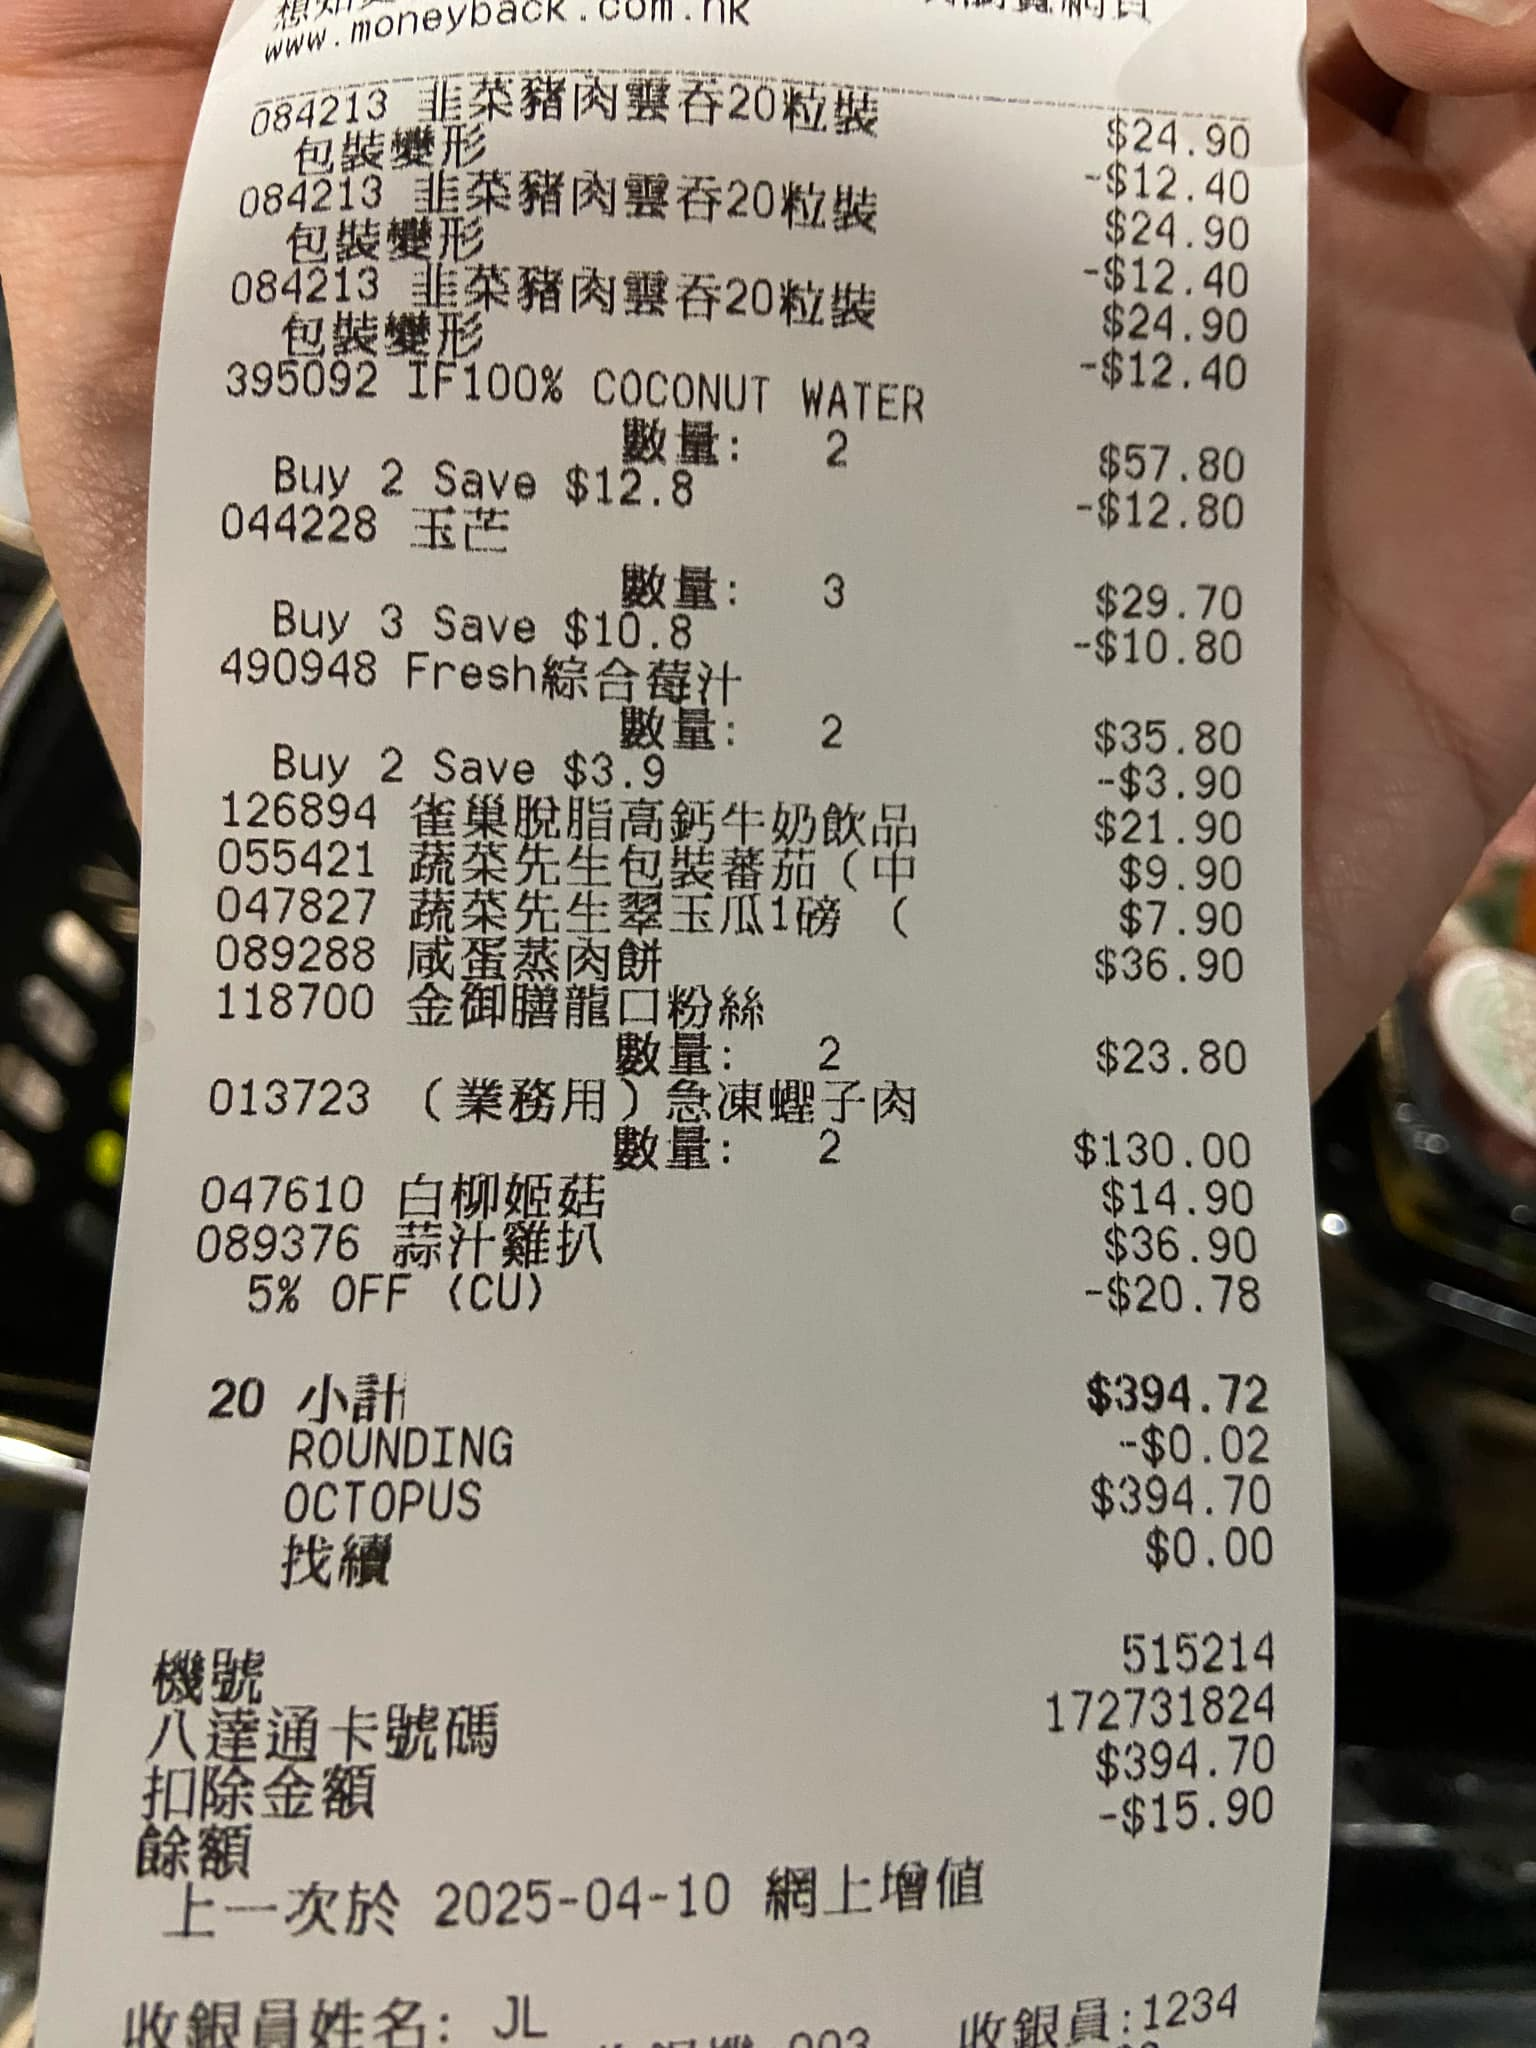
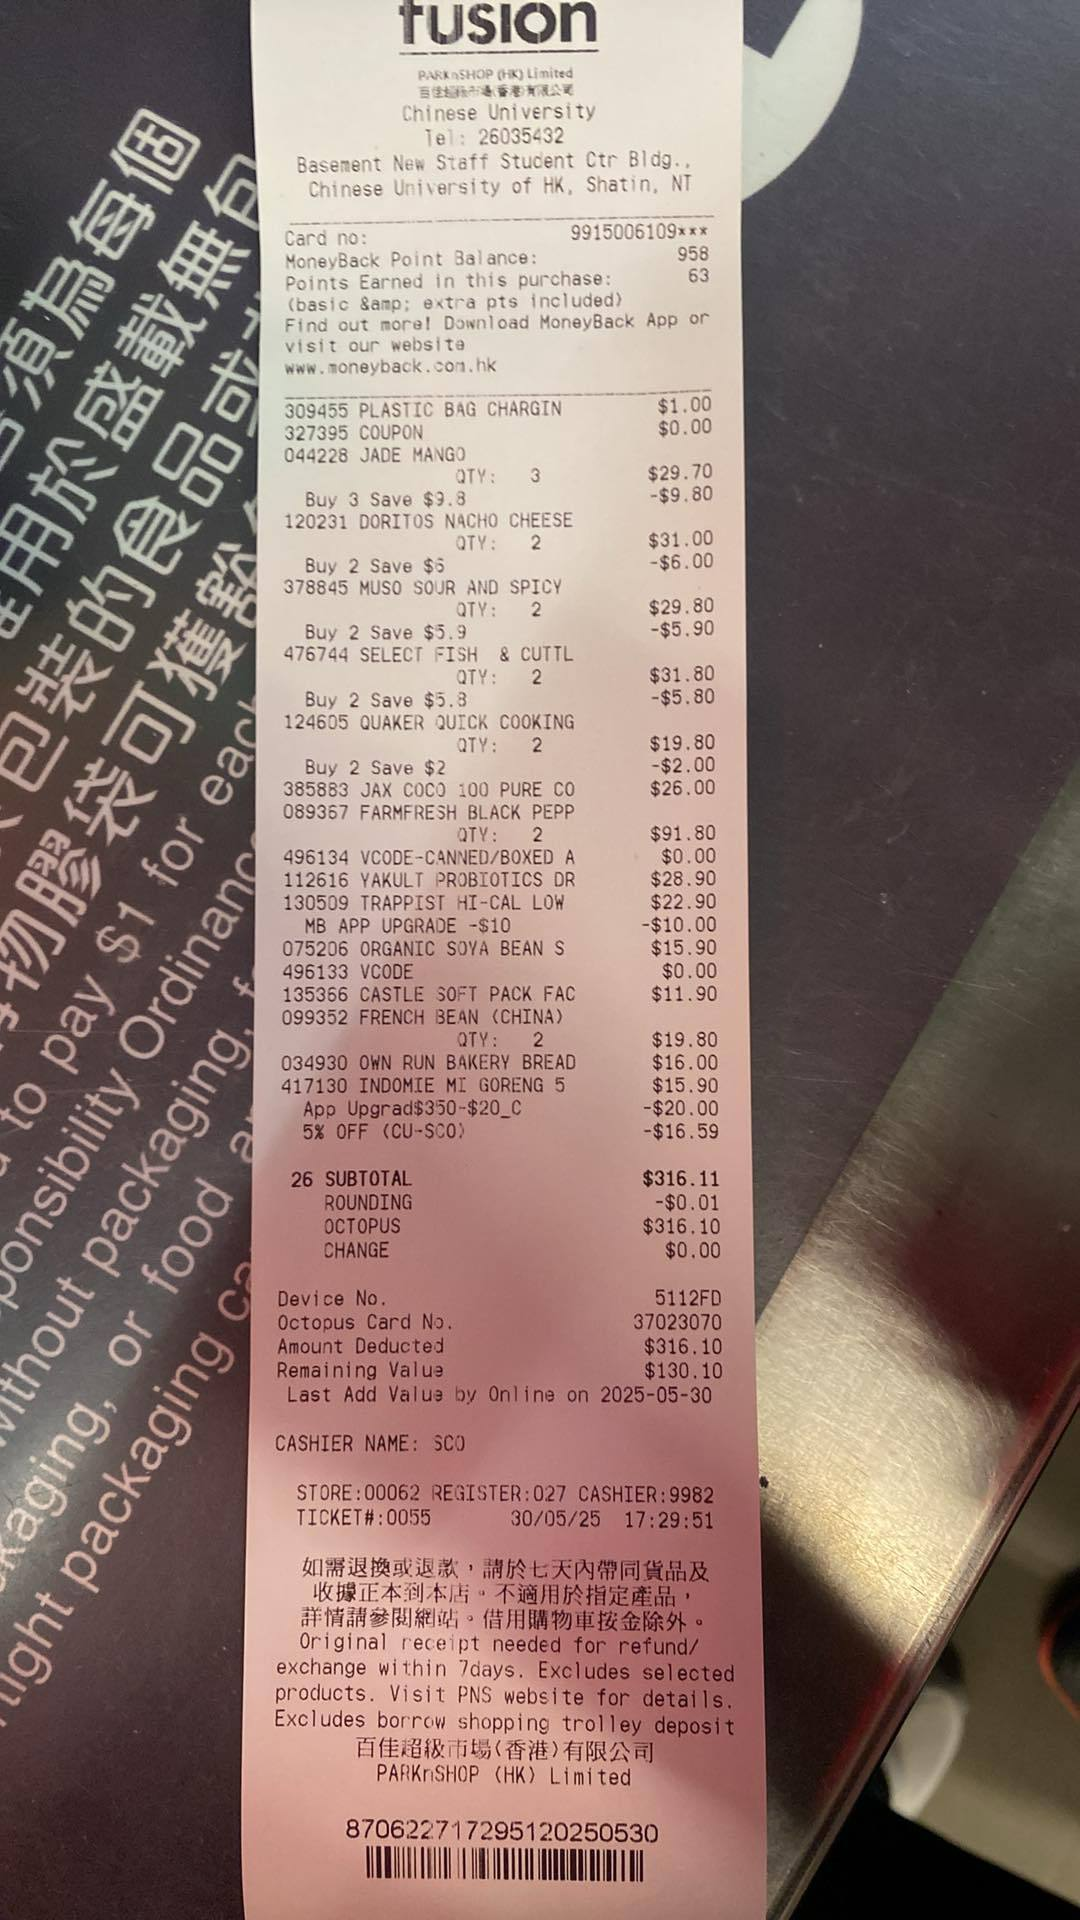
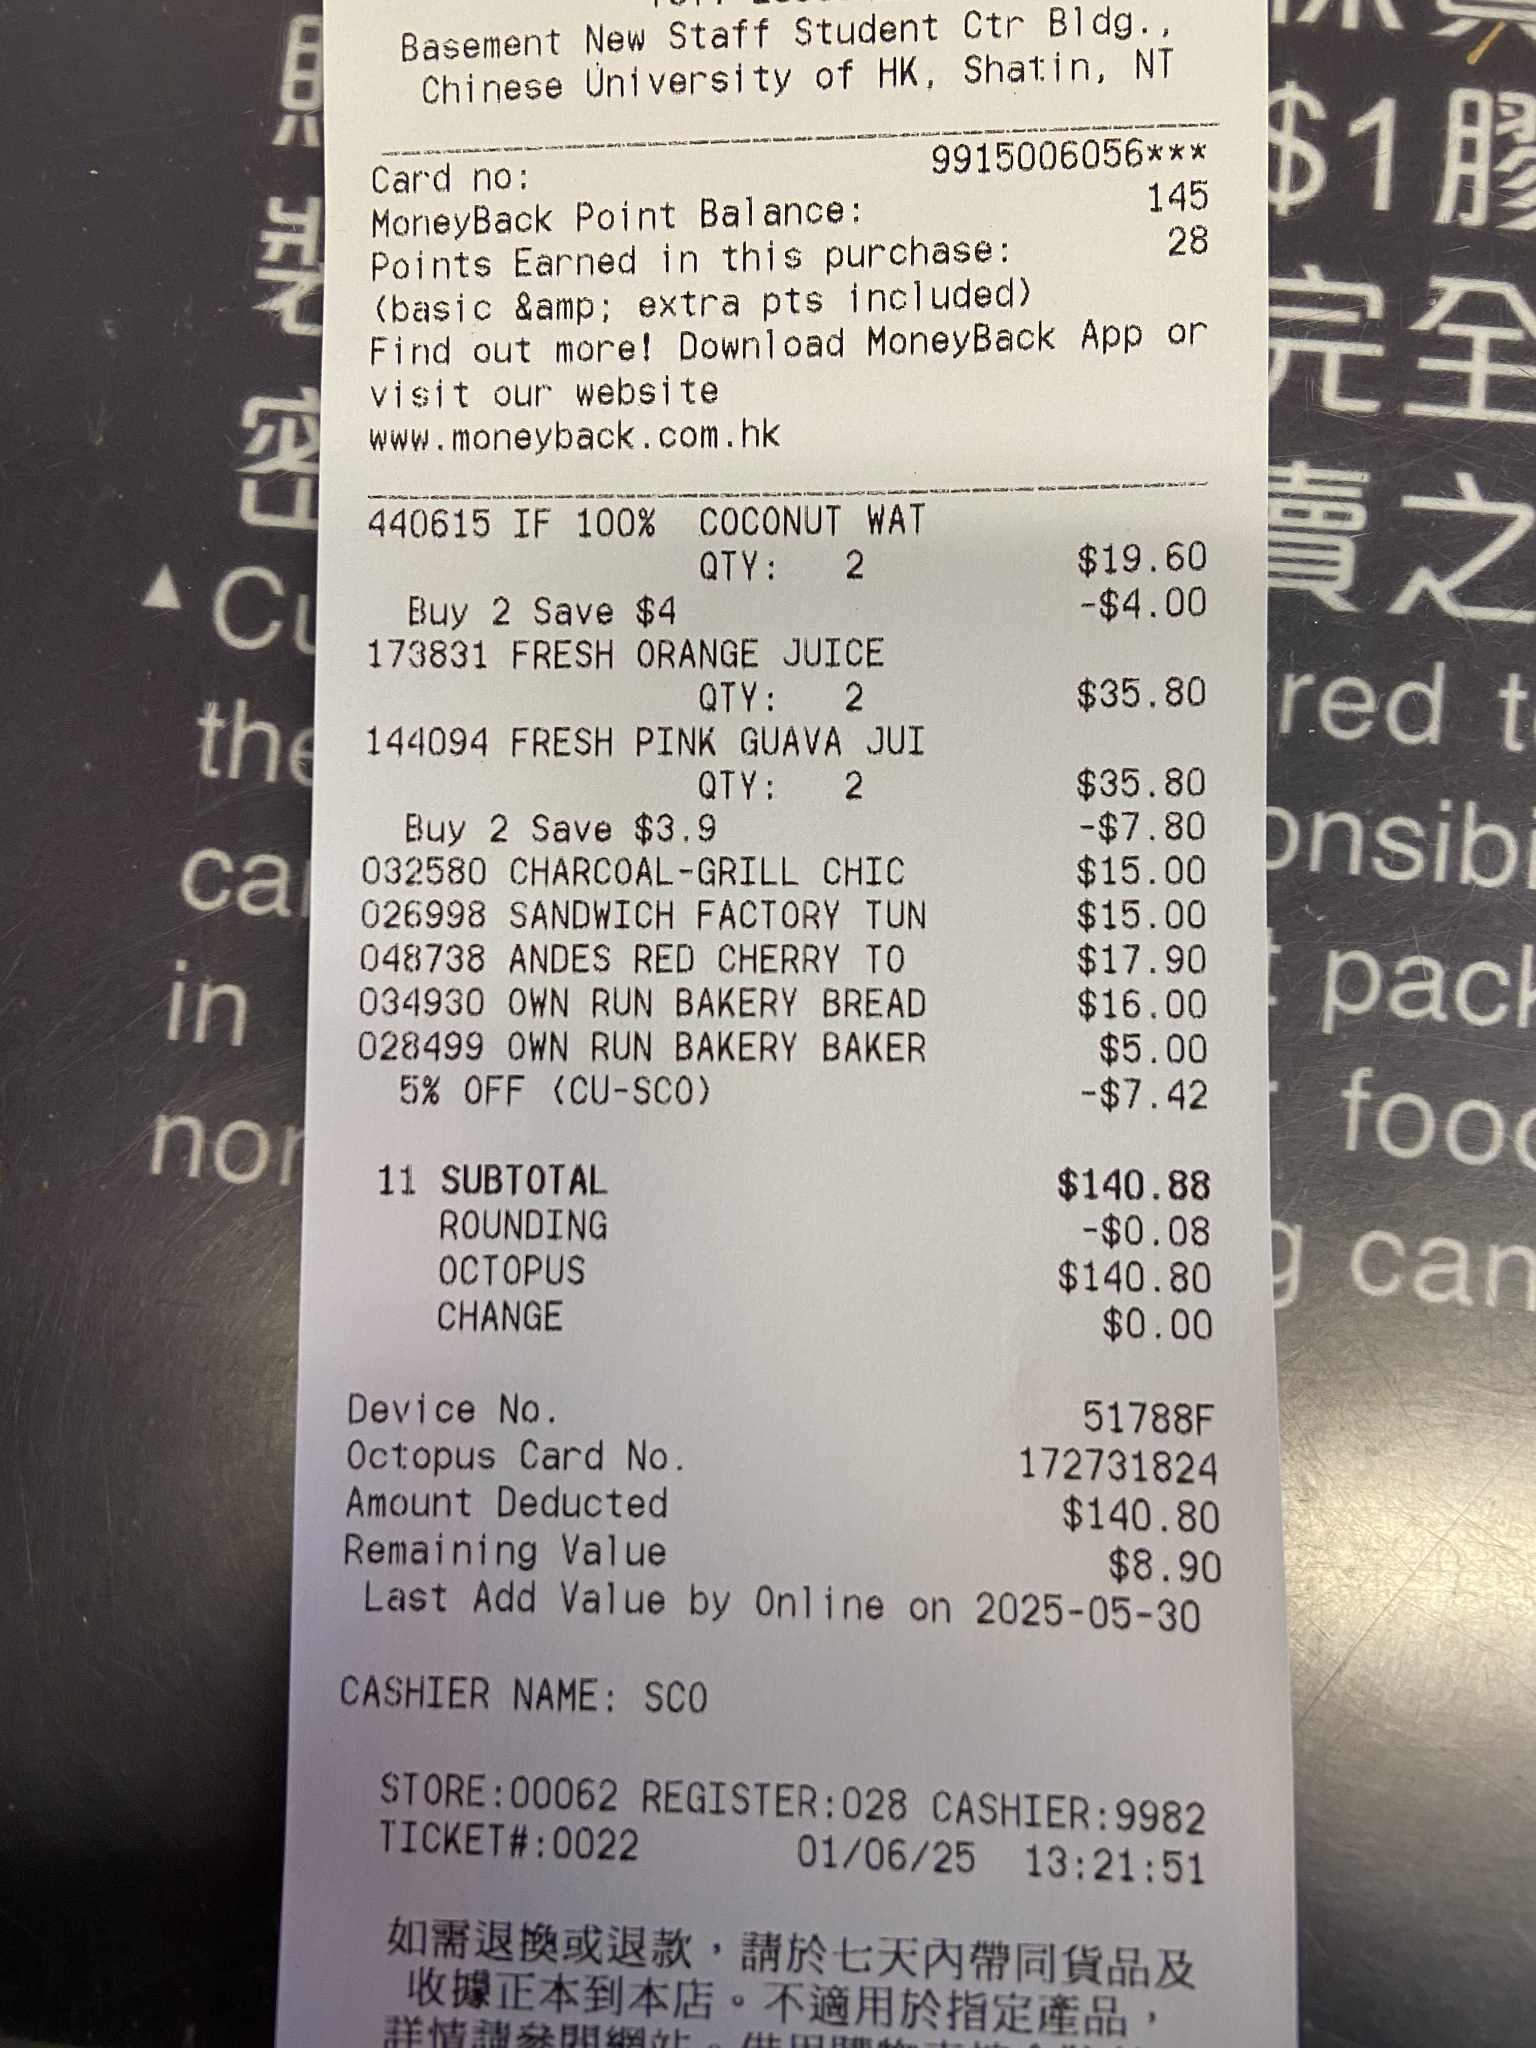
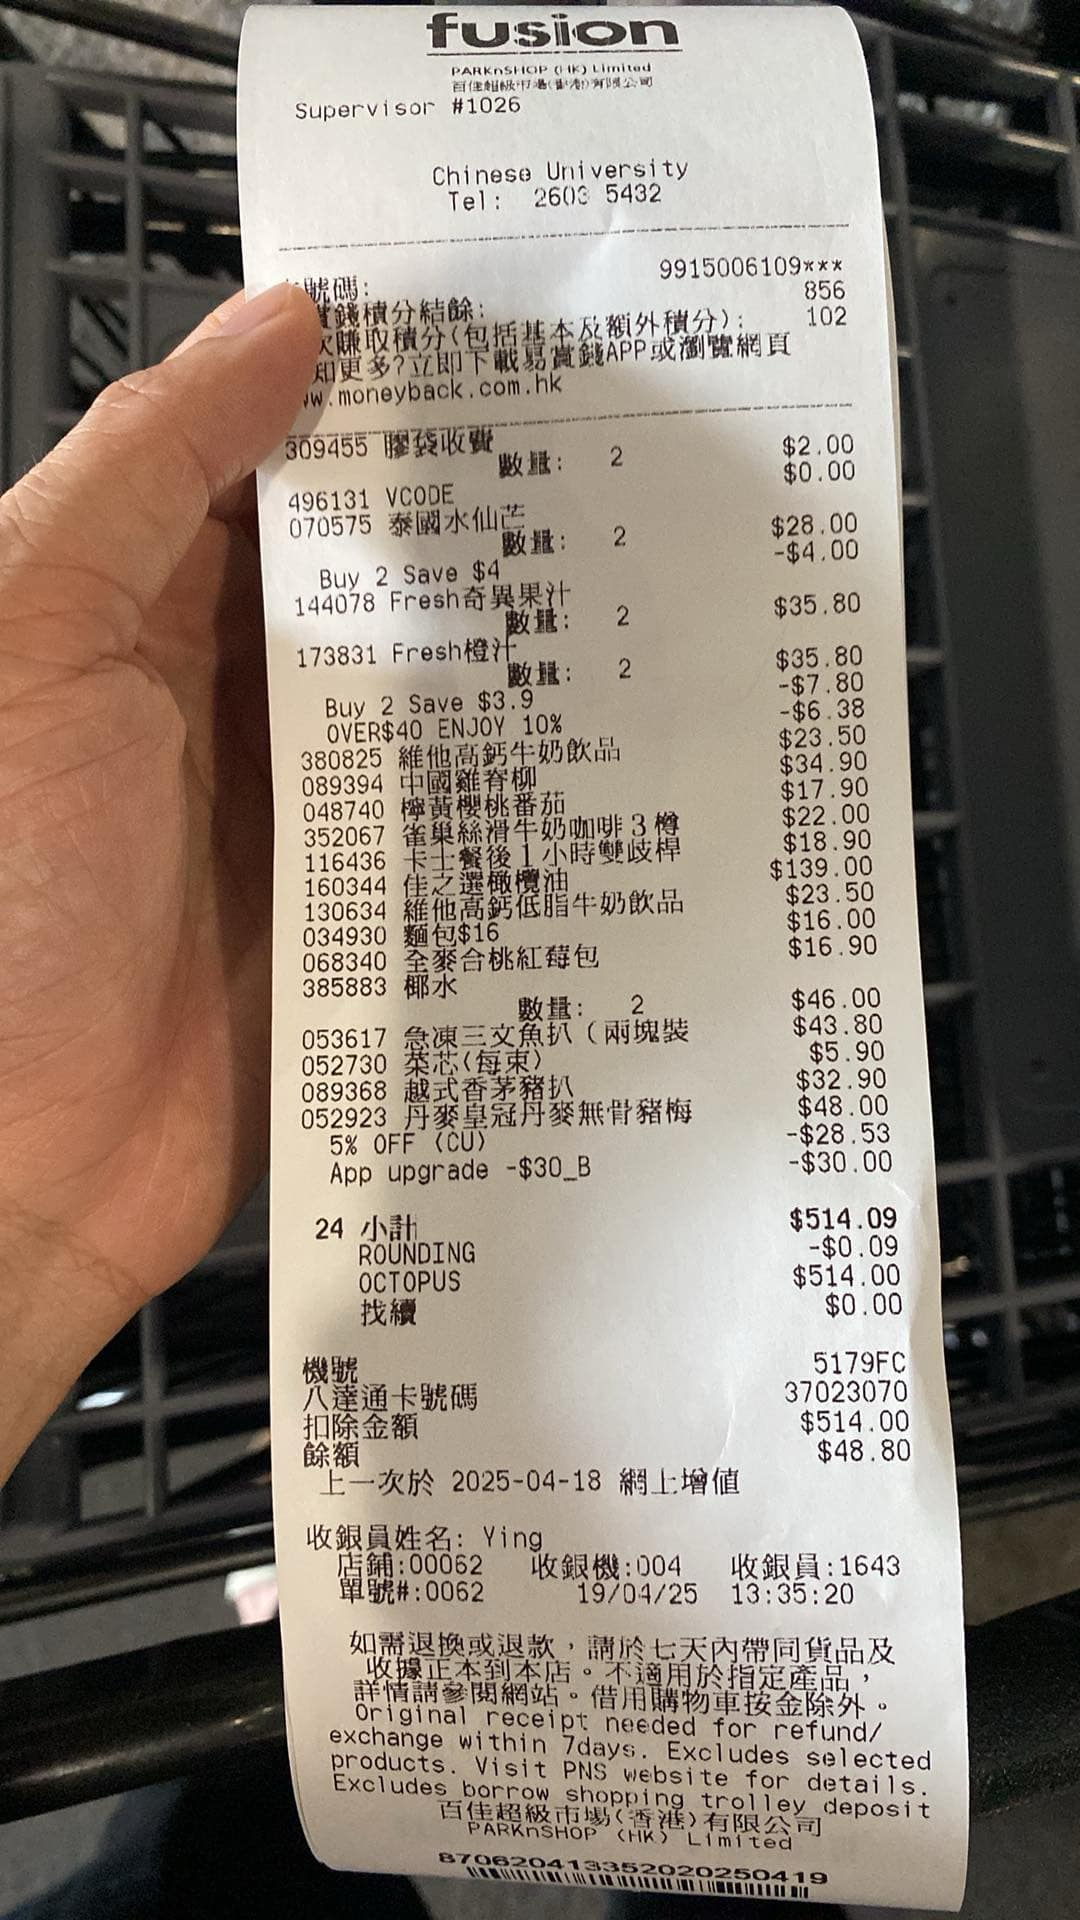
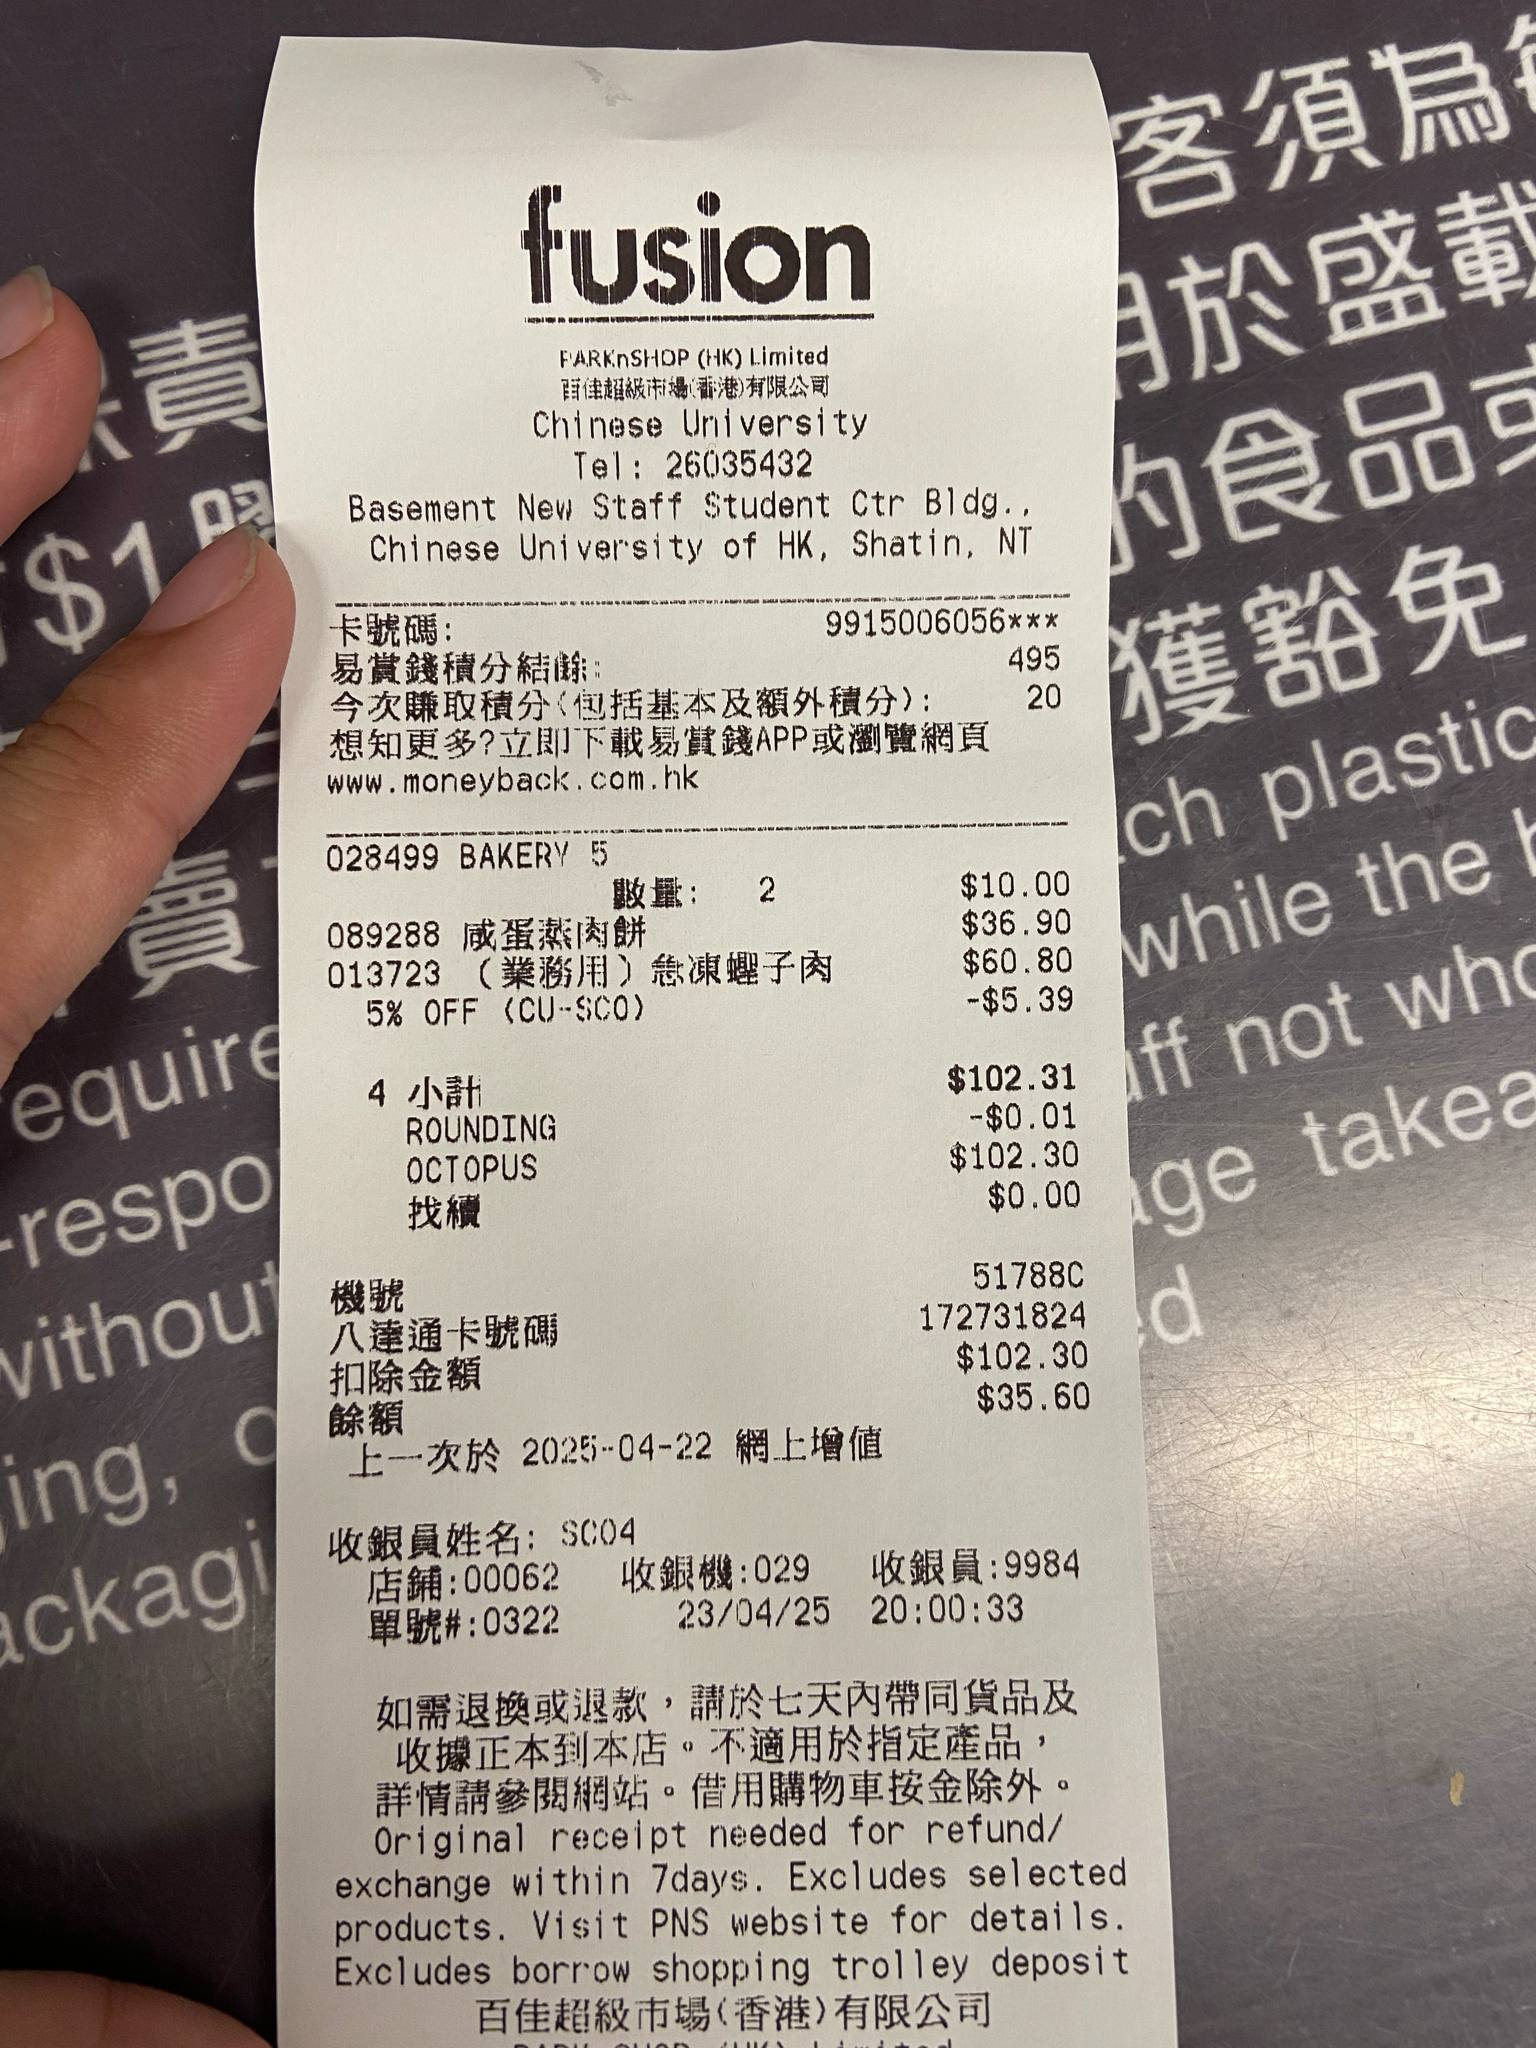
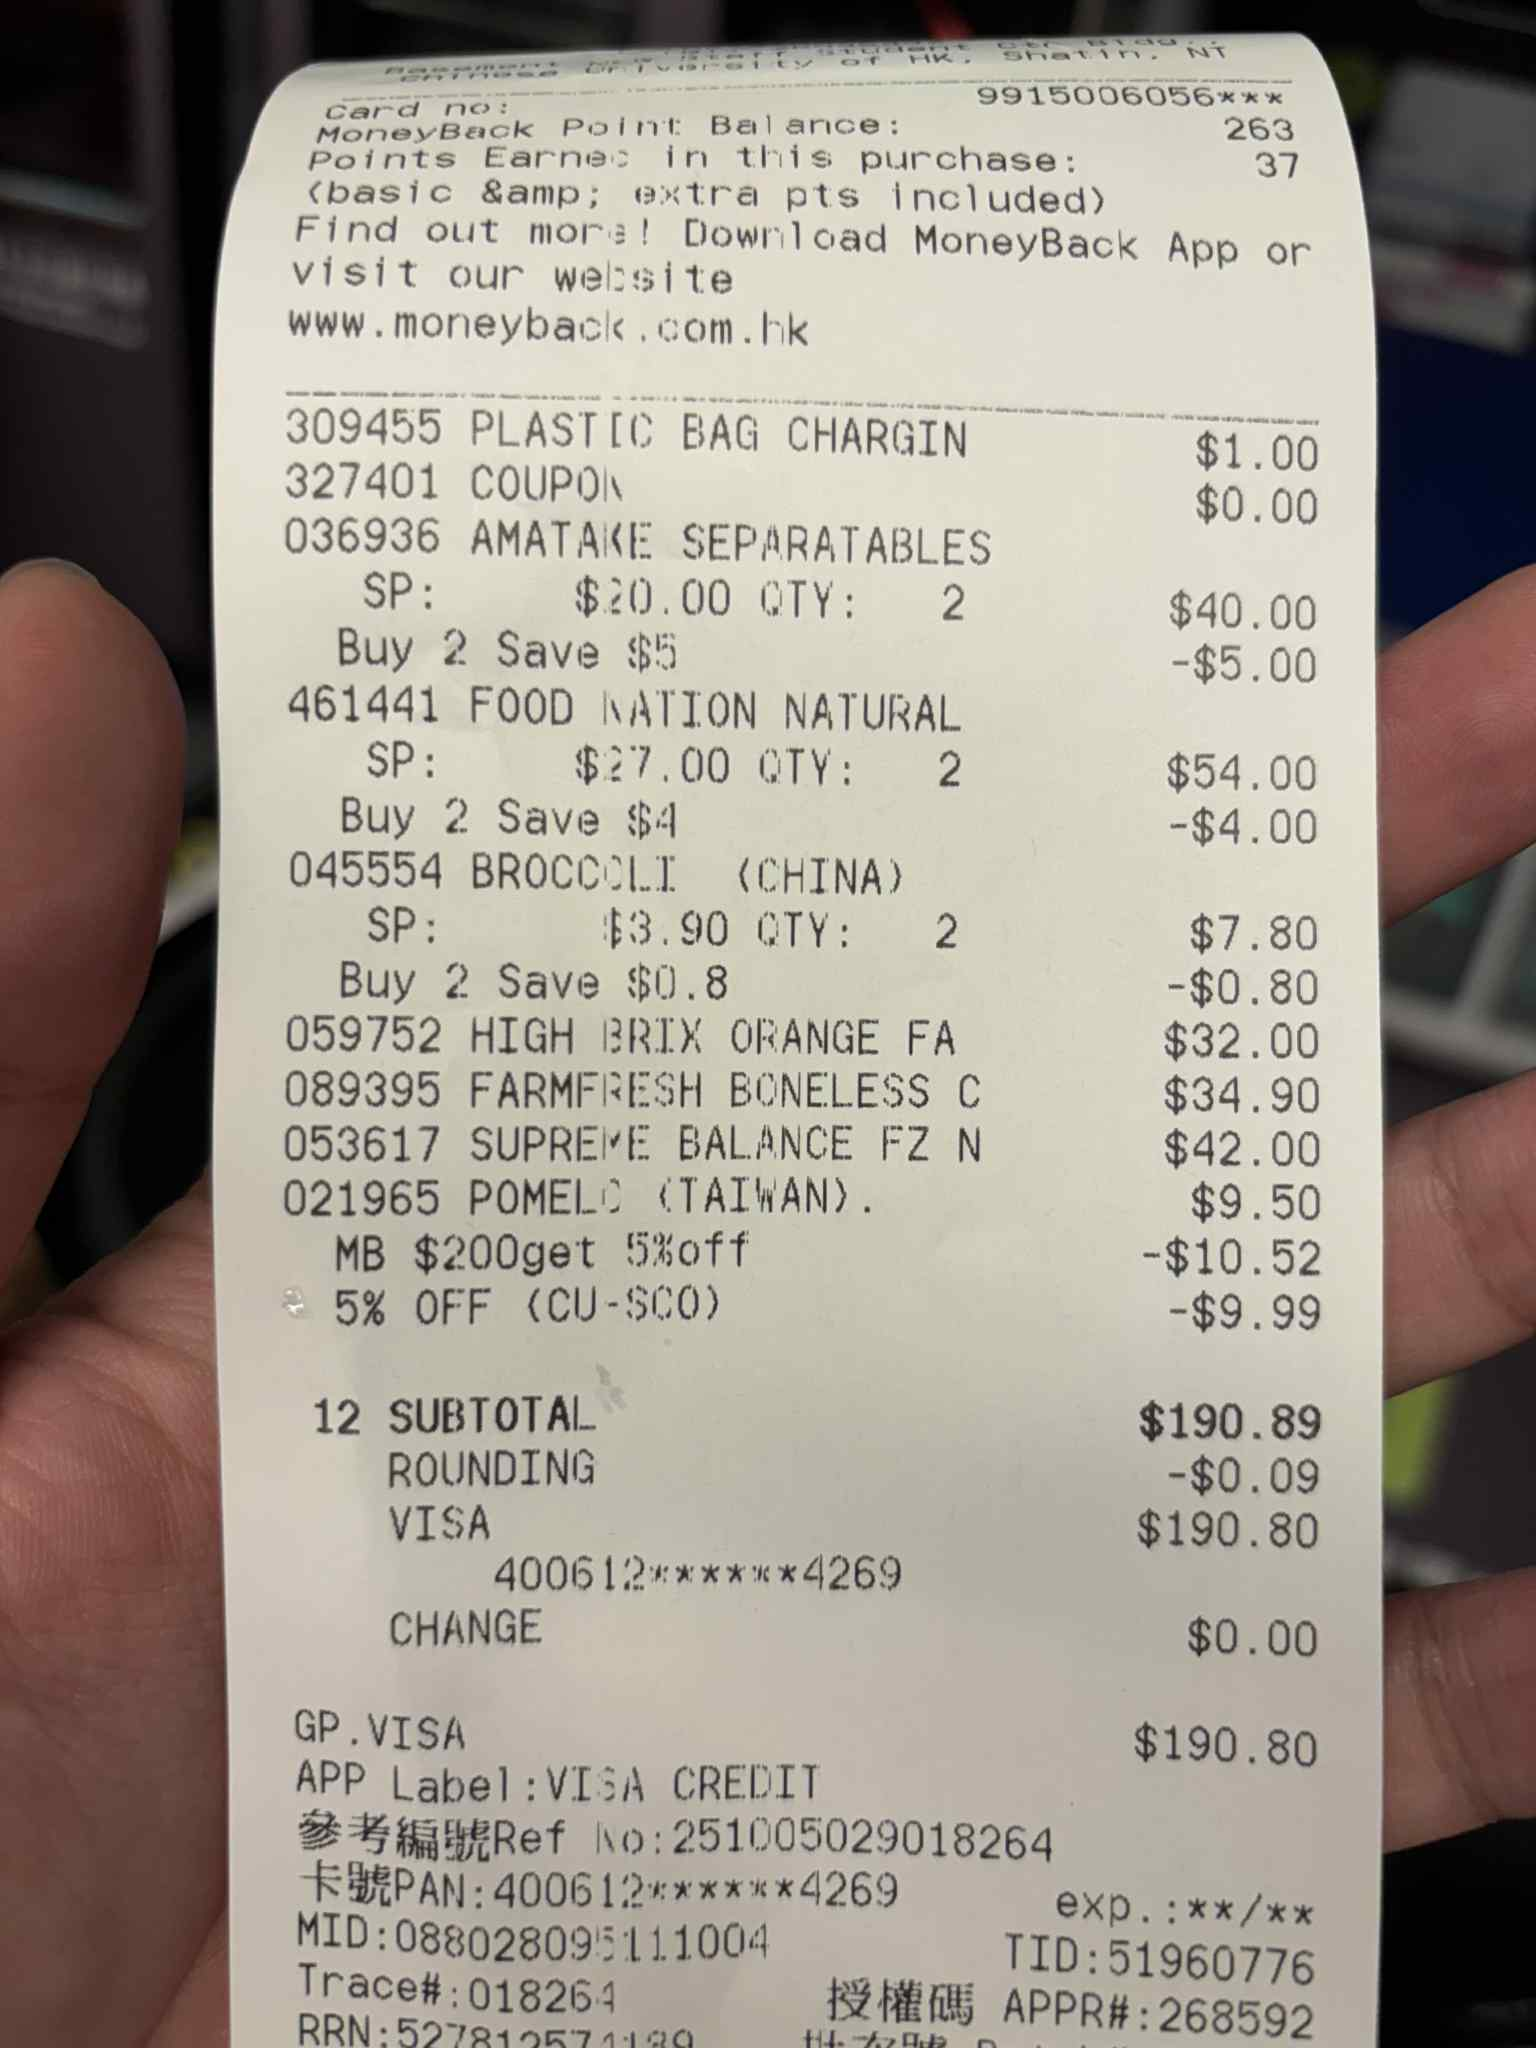
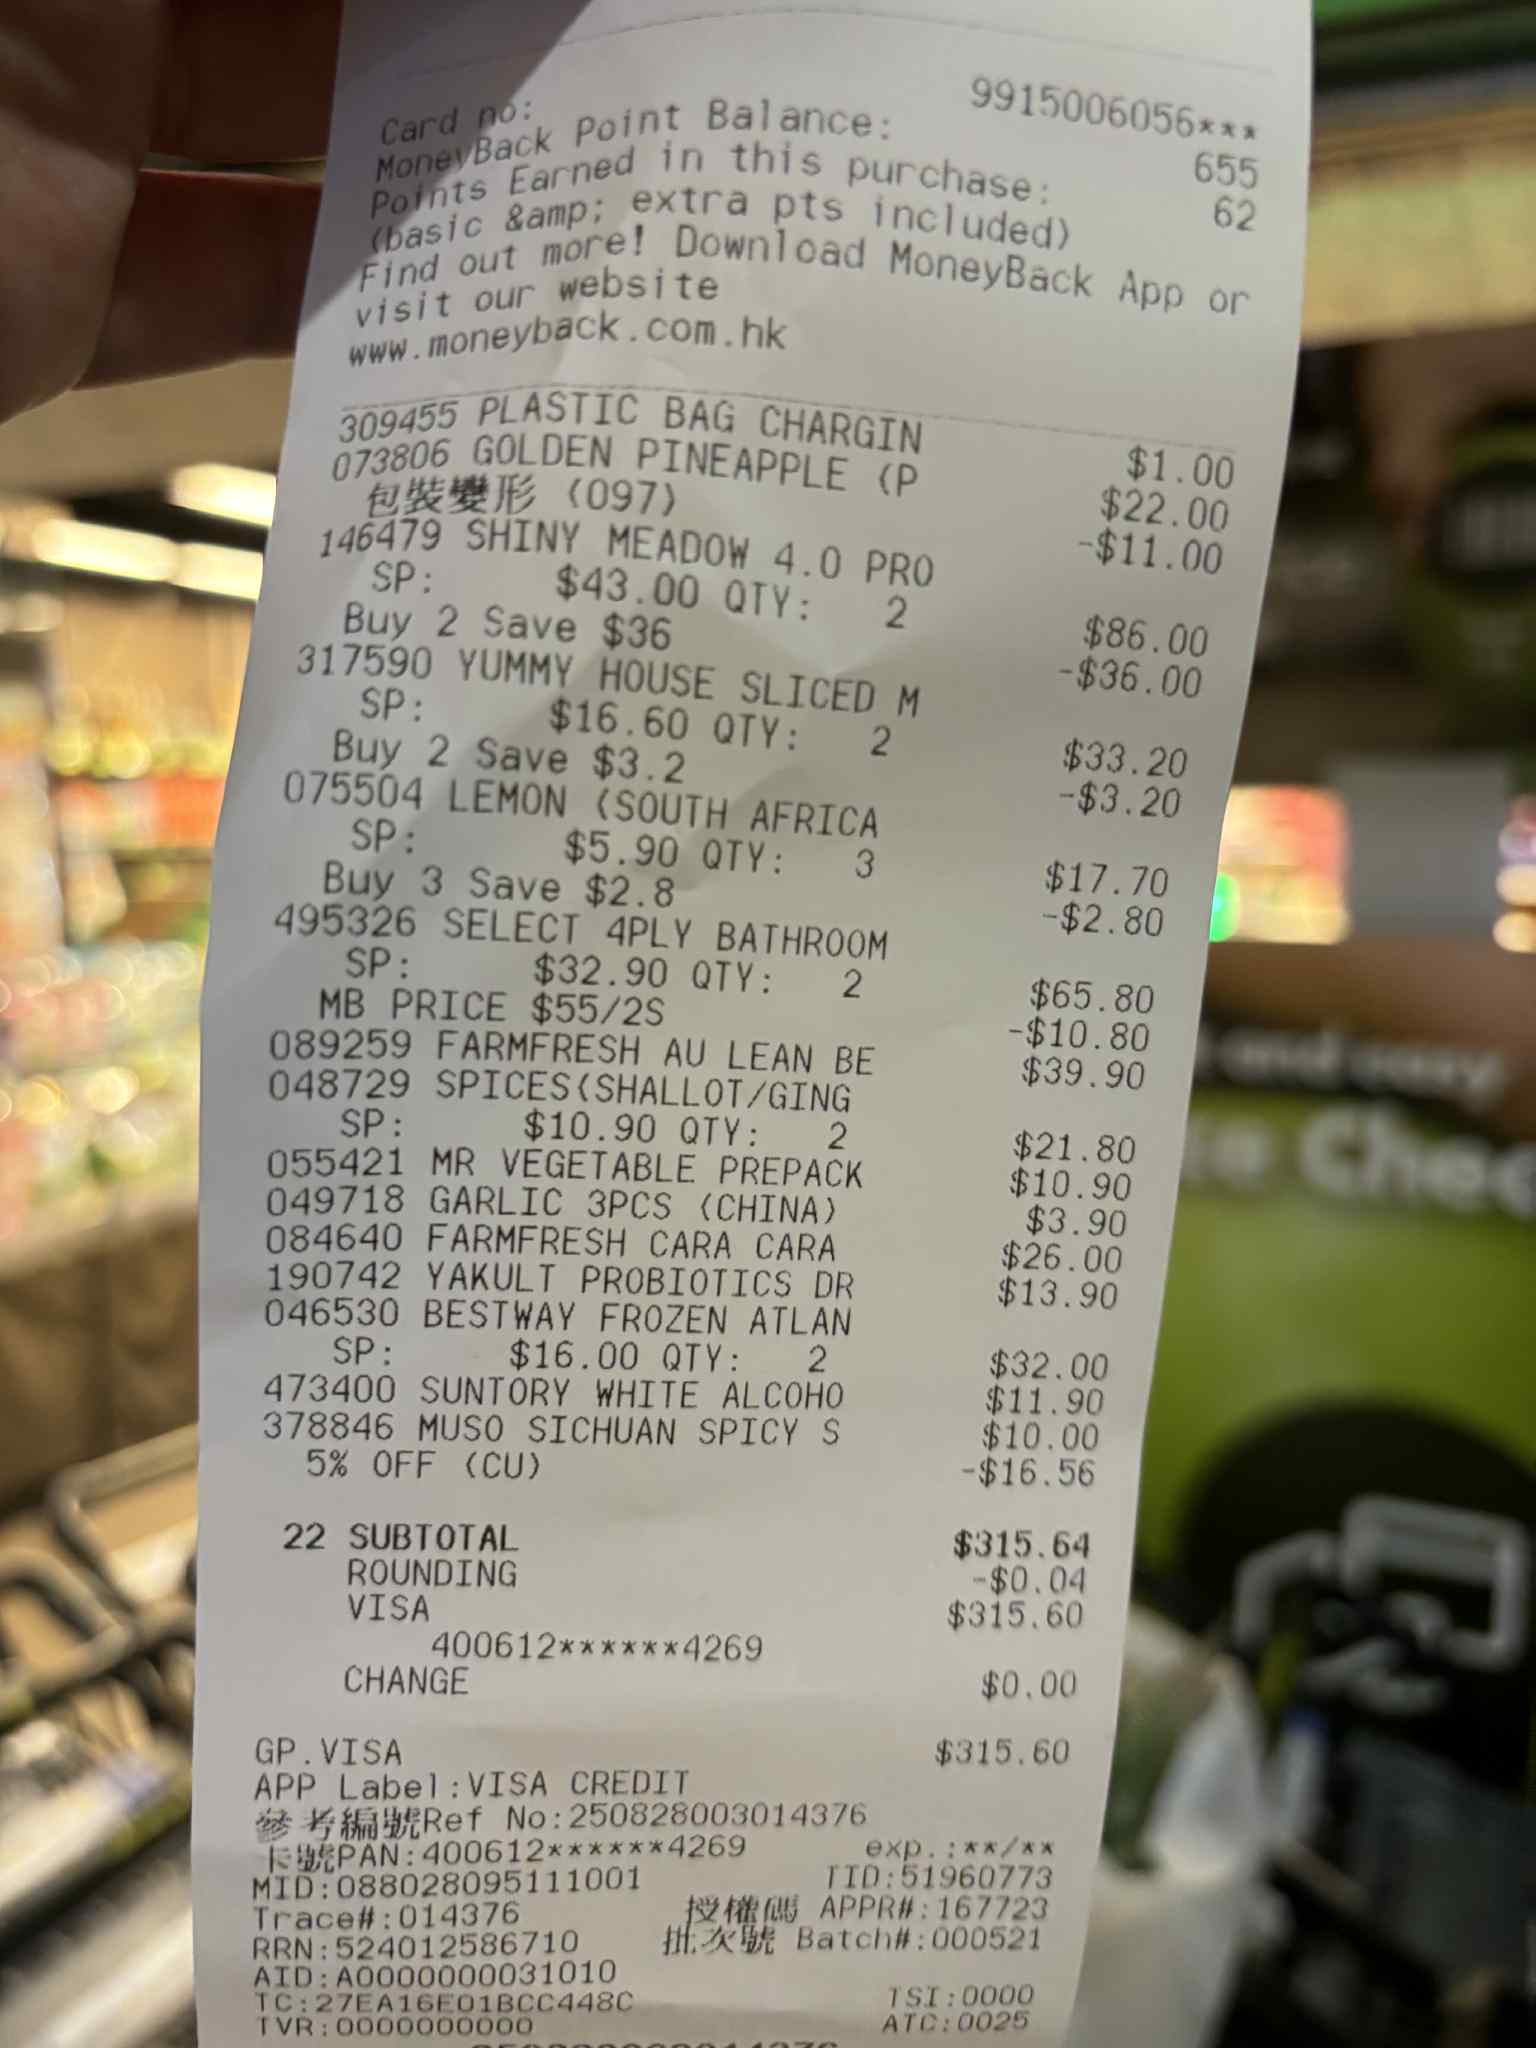


=== 批量执行所有查询 ===
处理 Query 1（实付总额）：How much money did I spend in total for these bills?...
模型结果：1974.3
处理 Query 2（折扣前原价总额）：How much would I have had to pay without the discount?...
模型结果：2348.2
处理 Query 3（无关：身份查询）：who are you?...
模型结果：IRRELEVANT
处理 Query 4（实付总额-同义）：What is the total amount I paid across all these receipts?...
模型结果：1974.3
处理 Query 5（原价总额-同义）：Calculate the total original price before any discounts were applied....
模型结果：2348.2
处理 Query 6（原价总额-带约束）：Calculate the total original price before discounts, do not include any account balance numbers....
模型结果：2348.2
处理 Query 7（无关：多意图）：How much did I spend in total, and what color is the shop logo?...
模型结果：IRRELEVANT
处理 Query 8（实付总额-中文）：计算所有小票的小计总和，不要包含任何余额...
模型结果：1974.64
处理 Query 9（无关：超市名称）：What is the name of the supermarket on these receipts?...
模型结果：IRRELEVANT
处理 Query 10（无关：交易日期）：What is the transaction date on each receipt?...
模型结果：IRRELEVANT
处理 Query 11（无关：购买物品）：List all the items I bought from these receipts....
模型结果：IRRELE

In [8]:
import base64
import mimetypes
import glob
import os
import re
from IPython.display import HTML, display
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from google.colab import userdata

# 配置Gemini Vertex AI模型
GEMINI_VERTEX_API_KEY = userdata.get('VERTEX_API_KEY')
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    api_key=GEMINI_VERTEX_API_KEY,
    temperature=0,
    vertexai=True
)

def image_to_base64(img_path):
    """将图片转换为Base64编码字符串"""
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def get_image_data_url(image_path):
    """生成模型可识别的图片Data URL（Base64+MIME类型）"""
    mime_type, _ = mimetypes.guess_type(image_path)
    mime_type = mime_type if mime_type else "image/png"
    encoded_string = image_to_base64(image_path)
    return f"data:{mime_type};base64,{encoded_string}"

def get_model_response(user_query):
    """调用Gemini模型，传入查询+收据图片，返回清洗后的结果"""
    # 加载并去重排序收据图片（支持多格式）
    image_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG"):
        image_paths.extend(glob.glob(ext))
    image_paths = sorted(list(set(image_paths)))
    if not image_paths:
        return "No images found."

    # 构造模型输入（文本+多张图片）
    message_content = [{"type": "text", "text": user_query}]
    for img_path in image_paths:
        message_content.append({
            "type": "image_url",
            "image_url": {"url": get_image_data_url(img_path)}
        })

    # 严格的会计规则系统指令（核心约束）
    system_instruction = """
    You are an expert accountant and receipt scanner. Your job is to extract financial data from images of supermarket bills.

    You will receive several images of receipts and a user query.
    Follow these rules strictly:

    RULE 1 (Total Spend):
    If the user asks "How much money did I spend in total?" (or similar),
    locate the final 'Total' or 'Balance Due' on EACH bill and sum them up

    RULE 2 (Calculate Original Total Price / Gross Amount):
    If the user asks "How much was the total before discounts?" or similar, calculate the sum of the original prices by reversing the discounts.
    Calculate the ORIGINAL TOTAL (before discounts) using this strict rule:
    ORIGINAL TOTAL = Total Paid (实付金额：收据中「小計」后的数字) + SUM of ALL discount amounts (所有带减号的消费类折扣金额)

    CRITICAL RULES (必须遵守)：
    1. ONLY include: 「小計」后的实付金额 + 消费项旁的带减号折扣（如-12.40、-30.00）
    2. NEVER include: 「餘額」/「余额」（账户余额），无论余额是正还是负（比如-500.00的余额完全忽略）
    3. List ALL discounts first (避免漏算)，再求和（只加折扣的绝对值）
    4. Must output a number > Total Paid (原价>实付)
    5. ONLY output the final number (no text, e.g., "486.10")

    RULE 3 (Irrelevant):
    If the user asks anything not related to the costs (e.g., "Is this healthy?", "What is the store name?"),
    reply exactly: "IRRELEVANT".

    OUTPUT FORMAT:
    - Return ONLY a single floating-point number representing the final calculated sum.
    - Do NOT include currency symbols (like $ or HKD).
    - Do NOT write sentences.
    - Example correct output: 154.50
    """

    # 调用模型并获取响应
    messages = [SystemMessage(content=system_instruction), HumanMessage(content=message_content)]
    response = llm.invoke(messages)
    raw_content = response.content

    # 统一清洗模型响应（适配字典/列表/字符串多格式）
    content = ""
    if isinstance(raw_content, dict):
        for key in raw_content.keys():
            if key.strip().upper() == "TEXT":
                content = str(raw_content[key])
                break
        content = content if content else str(raw_content)
    elif isinstance(raw_content, list):
        content = ''.join(map(str, raw_content))
    else:
        content = str(raw_content)
    content_clean = content.strip().upper()

    # 无关查询直接返回标识
    if "IRRELEVANT" in content_clean:
        return "IRRELEVANT"

    # 正则提取数字并转换为浮点型，非数字返回原始清洗结果
    try:
        match = re.search(r"[-+]?\d+\.?\d*", content.strip())
        return float(match.group()) if match else content.strip()
    except Exception:
        return content.strip()

def display_images():
    """可视化展示当前目录下的所有收据图片（带文件名、排版优化）"""
    image_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG"):
        image_paths.extend(glob.glob(ext))
    image_paths = sorted(list(set(image_paths)))

    if not image_paths:
        print("⚠️ Warning: No images found to display. Please upload receipt images first!")
        return

    html_content = '<div style="display: flex; flex-wrap: wrap; gap: 20px; padding: 10px;">'
    for path in image_paths:
        b64 = image_to_base64(path)
        filename = os.path.basename(path)
        html_content += f'''
        <div style="display: flex; flex-direction: column; align-items: center;">
            <img src="data:image/jpeg;base64,{b64}" style="height: 250px; border: 1px solid #ddd; border-radius: 4px; margin-bottom: 5px;"/>
            <span style="font-family: monospace; font-size: 12px; color: #333;">{filename}</span>
        </div>
        '''
    html_content += '</div>'
    display(HTML(html_content))

def test_query(question_name, answer, ground_truth_costs=None, is_irrelevant=False):
    """
    统一验证函数：支持3类查询验证（实付总额/原价总额/无关查询）
    :param question_name: 问题名称（如Query 1）
    :param answer: 模型返回结果
    :param ground_truth_costs: 真实标签数据（列表），无关查询传None
    :param is_irrelevant: 是否为无关查询，默认False
    """
    print(f"\n=== 验证 {question_name} ===")
    # 场景1：无关查询验证（检查是否返回IRRELEVANT）
    if is_irrelevant:
        if answer == "IRRELEVANT":
            print(f"✅ 验证通过：无关查询正确返回「IRRELEVANT」")
            print(f"模型结果：{answer} | 验证要求：返回IRRELEVANT")
        else:
            print(f"❌ 验证失败：无关查询未返回「IRRELEVANT」")
            print(f"模型结果：{answer} | 验证要求：返回IRRELEVANT")
        return

    # 场景2：无图片/空结果异常处理
    if answer is None or answer == "No images found.":
        print(f"❌ 验证失败：无效结果，未检测到收据图片！")
        print(f"模型结果：[{answer}]")
        return

    # 场景3：非数字结果异常处理
    try:
        model_val = float(answer)
    except (ValueError, TypeError):
        print(f"❌ 验证失败：模型结果无法转换为浮点型（非数值）")
        print(f"模型结果：[{answer}] | 验证要求：返回纯数字")
        return

    # 场景4：实付/原价总额数值验证（对比真实标签，误差≤2为通过）
    if ground_truth_costs and isinstance(ground_truth_costs, list):
        expected_total = sum(ground_truth_costs)
        abs_diff = abs(model_val - expected_total)
        print(f"真实结果：{expected_total:.2f} | 模型结果：{model_val:.2f}")
        print(f"绝对误差：{abs_diff:.2f} | 可接受误差：≤2.00")
        if abs_diff <= 2:
            print(f"✅ 验证通过：误差在可接受范围内")
        else:
            print(f"❌ 验证失败：误差超出可接受范围")
    else:
        print(f"⚠️ 提示：无真实标签数据，仅校验格式：模型结果为有效数字 {model_val:.2f}")

# ---------------------- 主程序执行 ----------------------
print("=== 加载并展示收据图片 ===")
display_images()

# 定义12个测试查询（分类：核心数值查询2个+无关查询10个）
queries = [
    ("Query 1（实付总额）", "How much money did I spend in total for these bills?", False, [394.7, 316.1, 140.8, 514.0, 102.3, 190.8, 315.6]),
    ("Query 2（折扣前原价总额）", "How much would I have had to pay without the discount?", False, [480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00]),
    ("Query 3（无关：身份查询）", "who are you?", True, None),
    ("Query 4（实付总额-同义）", "What is the total amount I paid across all these receipts?", False, [394.7, 316.1, 140.8, 514.0, 102.3, 190.8, 315.6]),
    ("Query 5（原价总额-同义）", "Calculate the total original price before any discounts were applied.", False, [480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00]),
    ("Query 6（原价总额-带约束）", "Calculate the total original price before discounts, do not include any account balance numbers.", False, [480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00]),
    ("Query 7（无关：多意图）", "How much did I spend in total, and what color is the shop logo?", True, None),
    ("Query 8（实付总额-中文）", "计算所有小票的小计总和，不要包含任何余额", False, [394.7, 316.1, 140.8, 514.0, 102.3, 190.8, 315.6]),
    ("Query 9（无关：超市名称）", "What is the name of the supermarket on these receipts?", True, None),
    ("Query 10（无关：交易日期）", "What is the transaction date on each receipt?", True, None),
    ("Query 11（无关：购买物品）", "List all the items I bought from these receipts.", True, None),
    ("Query 12（无关：支付方式）", "Did I pay with credit card or cash for these bills?", True, None),
]

# 批量执行查询并存储结果
query_answers = []
print("\n=== 批量执行所有查询 ===")
for name, text, is_irr, gt in queries:
    print(f"处理 {name}：{text}...")
    ans = get_model_response(text)
    query_answers.append(ans)
    print(f"模型结果：{ans}")

# 批量执行全量验证（核心：12个问题逐个输出验证结果）
print("\n" + "="*50)
print("=== 所有查询验证结果汇总 ===")
print("="*50)
for idx, (name, text, is_irr, gt) in enumerate(queries):
    test_query(name, query_answers[idx], gt, is_irr)

# 单独提取核心查询结果（可选，方便后续二次分析）
query1_answer = query_answers[0]  # Query 1结果
query2_answer = query_answers[1]  # Query 2结果
query3_answer = query_answers[2]  # Query 3结果